# **JSON GoPro metadata processing**

# Data display

First let us import the data. Change the paths if needed.

In [52]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

with open("../json/GH010025.MP4.json", "r") as f:
    video1_data1 = json.load(f)
with open("../json/GH020025.MP4.json", "r") as f:
    video1_data2 = json.load(f)

with open("../json/GH010024.MP4.json", "r") as f:
    video2_data1 = json.load(f)
with open("../json/GH020024.MP4.json", "r") as f:
    video2_data2 = json.load(f)
with open("../json/GH030024.MP4.json", "r") as f:
    video2_data3 = json.load(f)
list_data = [video1_data1, video1_data2, video2_data1, video2_data2, video2_data3]

The following 2 blocks of code allow to visualize the data to check if it is the correct data.

In [53]:
# Voir les clés principales
for i, data in enumerate(list_data):
    print(f"Data {i+1} keys:")
    print(data.keys())
    print()

Data 1 keys:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])

Data 2 keys:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])

Data 3 keys:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])

Data 4 keys:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])

Data 5 keys:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])



In [54]:
from pprint import pprint
with open("../json/GH010025.MP4.json", "r") as f:
    data = json.load(f)

# Affiche récursivement la structure jusqu’à une profondeur de 2 ou 3
for key in data:
    print(f"\n== Clé principale : {key} ==")
    if isinstance(data[key], dict):
        for subkey in data[key]:
            print(f"  - {subkey}: type={type(data[key][subkey])}")
            if isinstance(data[key][subkey], list) and len(data[key][subkey]) > 0:
                print(f"    Exemple d’entrée : {data[key][subkey][0]}")
    elif isinstance(data[key], list) and len(data[key]) > 0:
        print(f"  Liste de longueur {len(data[key])}")
        print(f"  Exemple d’entrée : {data[key][0]}")
    else:
        print(f"  Type: {type(data[key])}, Valeur: {data[key]}")


== Clé principale : img_timestamps_s ==
  Liste de longueur 42420
  Exemple d’entrée : 0.0

== Clé principale : ACCL ==
  - data: type=<class 'list'>
    Exemple d’entrée : [9.470023980815348, -1.223021582733813, 2.338129496402878]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.001331

== Clé principale : GYRO ==
  - data: type=<class 'list'>
    Exemple d’entrée : [0.003194888178913738, 0.0, -0.0010649627263045794]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.001331

== Clé principale : GPS5 ==
  - data: type=<class 'list'>
    Exemple d’entrée : [48.6139418, 2.4291544, 96.877, 0.0, 0.0]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.050368

== Clé principale : GRAV ==
  - data: type=<class 'list'>
    Exemple d’entrée : [-0.12784203619495224, 0.9633777886288034, 0.23560289315469832]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.0

== Clé principale : MAGN ==
  - data: type=<class 'list'>
    Exemple d’entrée : [36.0,

The following block of code concatenates a list of multiple .MP4 GoPro metadata json variables into one for easier manipulation and interpretation into one .MP4 file.

In [55]:
list_data_video1 = [video1_data1, video1_data2]
list_data_video2 = [video2_data1, video2_data2, video2_data3]

def concatenate_dicts_by_key(dict_list):
    """
    Concatenates a list of dictionaries with potentially nested structures,
    ensuring that 'timestamps_s' values are stacked (i.e., made continuous).

    Parameters
    ----------
    dict_list : list of dict
        A list of dictionaries where each dictionary may contain nested structures

    Returns
    -------
    merged: dict.
        A single merged dictionary with combined and time-shifted values.
    """
    merged = {}
    time_offsets = {}  # Store per-key offset for nested timestamps

    for d in dict_list:
        for key, value in d.items():
            if isinstance(value, dict):
                # Nested dictionary (e.g., ACCL: {data: [...], timestamps_s: [...]})
                if key not in merged:
                    merged[key] = {}
                    time_offsets[key] = 0.0

                # Prepare nested structure if needed
                for sub_key, sub_val in value.items():
                    if sub_key not in merged[key]:
                        merged[key][sub_key] = []

                    if sub_key == "timestamps_s":
                        # Offset this timestamp list
                        offset = time_offsets[key]
                        shifted = [t + offset for t in sub_val]
                        merged[key][sub_key].extend(shifted)

                        # Update offset: assume timestamps_s is sorted
                        if sub_val:
                            time_offsets[key] += sub_val[-1] - sub_val[0]
                    else:
                        merged[key][sub_key].extend(sub_val)

            elif isinstance(value, list):
                # Flat key like img_timestamps_s (we treat it like timestamps)
                if key not in merged:
                    merged[key] = []
                    time_offsets[key] = 0.0

                if key.endswith("timestamps_s"):
                    offset = time_offsets[key]
                    shifted = [t + offset for t in value]
                    merged[key].extend(shifted)
                    if value:
                        time_offsets[key] += value[-1] - value[0]
                else:
                    merged[key].extend(value)

            else:
                print(f"Unexpected value type for key '{key}': {type(value)}")
                if key not in merged:
                    merged[key] = []
                merged[key].append(value)

    return merged


data_video1 = concatenate_dicts_by_key(list_data_video1)
data_video2 = concatenate_dicts_by_key(list_data_video2)

The following block checks if the concatenation worked by displaying the results.

In [56]:
print("Data Video 1:")
print(data_video1.keys())
key = "ACCL"
samples = data_video1[key]
print(f"Number of samples in {key}: {len(samples)}")

print("Data Video 2:")
print(data_video2.keys())

# Print the length of the ACCL samples before and after the concatenation
print(f"Number of samples in {key}: {len(data_video1[key]['data'])}")
print(f"Number of samples in {key}: {len(video1_data1[key]['data'])} +", f"{len(video1_data2[key]['data'])}", f"= {len(video1_data1[key]['data']) + len(video1_data2[key]['data'])}")

Data Video 1:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])
Number of samples in ACCL: 2
Data Video 2:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])
Number of samples in ACCL: 237913
Number of samples in ACCL: 141058 + 96855 = 237913


The following blocks plot all sensor data with one graph for each sensor and each video. For now there are no units on the y-axis, read the documentation for that.

In [57]:
def parse_video_dict(video_dict):
    """
    Converts a sensor dictionary into a dict of DataFrames per sensor (one DataFrame for ACCL, one for GRAV and so on).
    """
    dict_of_dfs = {}
    for key, value in video_dict.items():
        # Skip if key is just the image timestamps
        if key == "img_timestamps_s":
            continue

        if isinstance(value, dict) and "data" in value and "timestamps_s" in value:
            samples = value["data"]
            timestamps = value["timestamps_s"]

            # Skip if no data or inconsistent
            if not samples or not timestamps or len(samples) != len(timestamps):
                print(f"Skipping {key}: no data or inconsistent lengths.")
                continue

            num_cols = len(samples[0]) if isinstance(samples[0], (list, tuple)) else 1# check if samples is a list of lists or a single list
            if num_cols == 1:
                df = pd.DataFrame({f"{key}_0": samples})
            else:
                col_names = [f"{key}_{i}" for i in range(num_cols)]
                df = pd.DataFrame(samples, columns=col_names)

            df["time"] = timestamps
            df["time_rel"] = df["time"] - df["time"][0] # starting from 0 for plotting
            dict_of_dfs[key] = df

    return dict_of_dfs

def plot_sensor_data(dict_of_dfs, label_prefix=""):
    """
    Plots each sensor column separately from a dict of DataFrames.

    Parameters
    ----------
    dict_of_dfs : dict
        Dictionary mapping sensor names to pandas DataFrames.
    label_prefix : str, optional
        Prefix to add to the title of each plot (e.g., video name or label).
    """
    for key, df in dict_of_dfs.items():
        if df.empty or "time_rel" not in df:
            print(f"Skipping {key}: DataFrame is empty or missing 'time_rel' column.")
            continue

        value_cols = [col for col in df.columns if col not in ["time", "time_rel"]]
        for col in value_cols:
            plt.figure(figsize=(10, 4))
            plt.plot(df["time_rel"], df[col], label=col)
            plt.xlabel("Temps relatif (s)")
            plt.ylabel(col)
            plt.title(f"{label_prefix}{key} - {col} en fonction du temps")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

# Create DataFrames for each video
dfs_video_1 = parse_video_dict(data_video1)
dfs_video_2 = parse_video_dict(data_video2)

# Verifies that the DataFrames were created correctly with 1 column for index, 1 for timestamps, and 3-5 for data
print("DataFrames for Video 1:")
for key, df in dfs_video_1.items():
    print(f"{key}: {df.shape[0]} rows, {df.shape[1]} columns")
print("DataFrames for Video 2:")
for key, df in dfs_video_2.items():
    print(f"{key}: {df.shape[0]} rows, {df.shape[1]} columns")

DataFrames for Video 1:
ACCL: 237913 rows, 5 columns
GYRO: 237913 rows, 5 columns
GPS5: 21569 rows, 7 columns
GRAV: 71552 rows, 5 columns
MAGN: 29739 rows, 5 columns
CORI: 71552 rows, 6 columns
IORI: 71552 rows, 6 columns
DataFrames for Video 2:
ACCL: 313522 rows, 5 columns
GYRO: 313522 rows, 5 columns
GPS5: 28557 rows, 7 columns
GRAV: 94300 rows, 5 columns
MAGN: 39190 rows, 5 columns
CORI: 94300 rows, 6 columns
IORI: 94300 rows, 6 columns


Video 1 DataFrames: ----------------------------------------------------------------------------------------------------


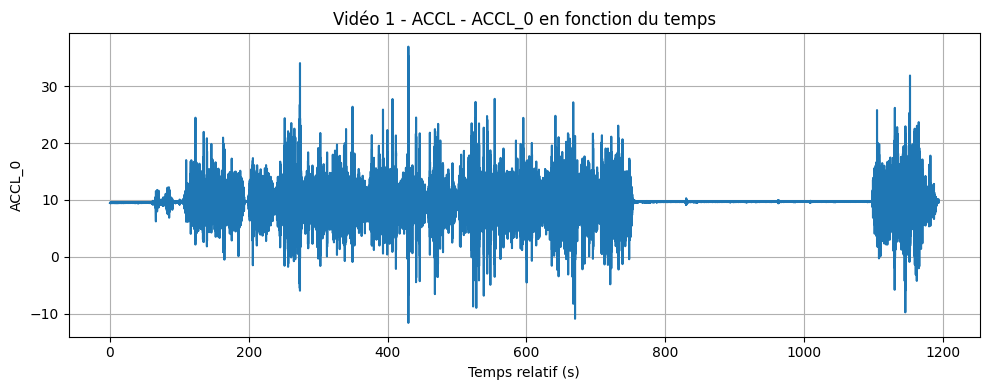

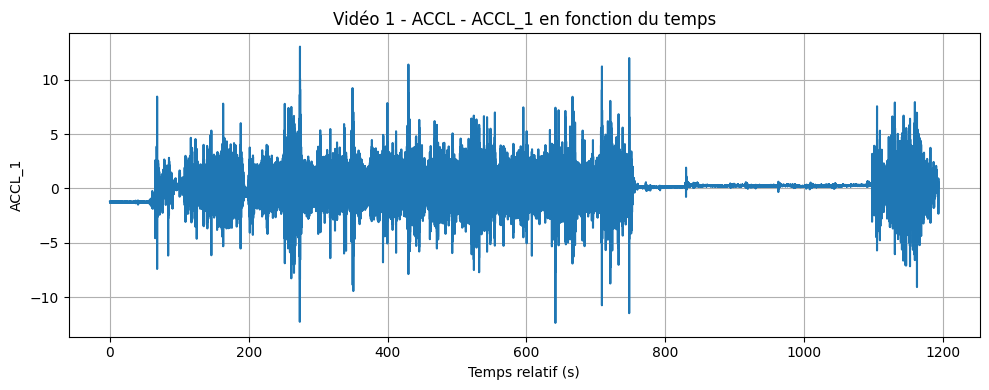

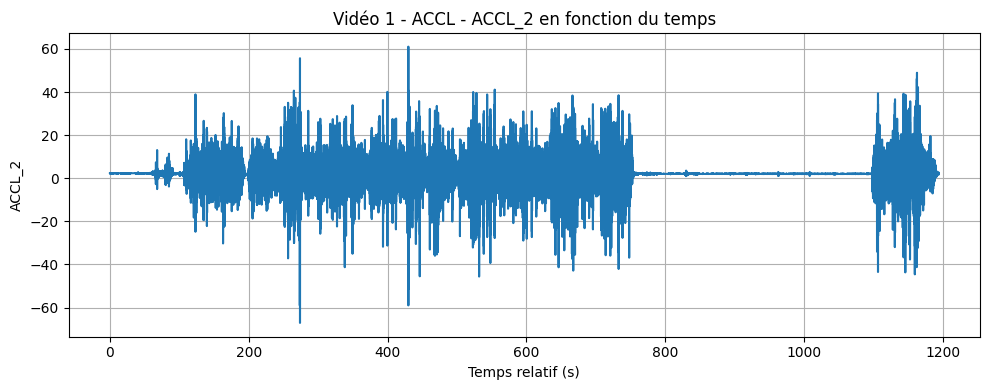

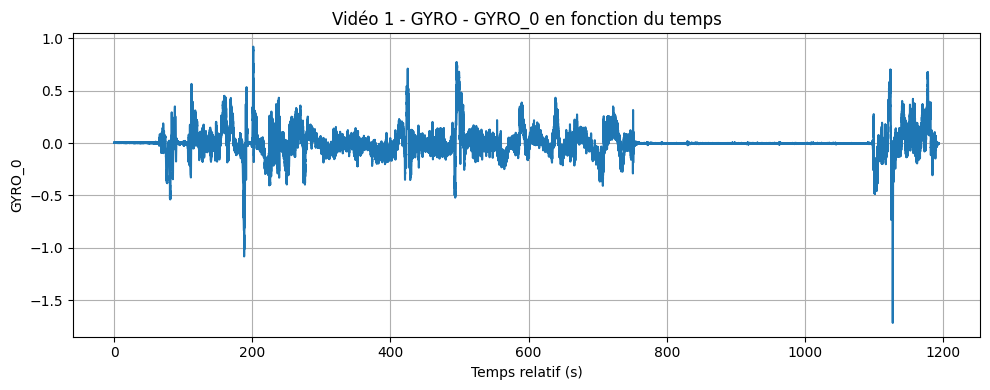

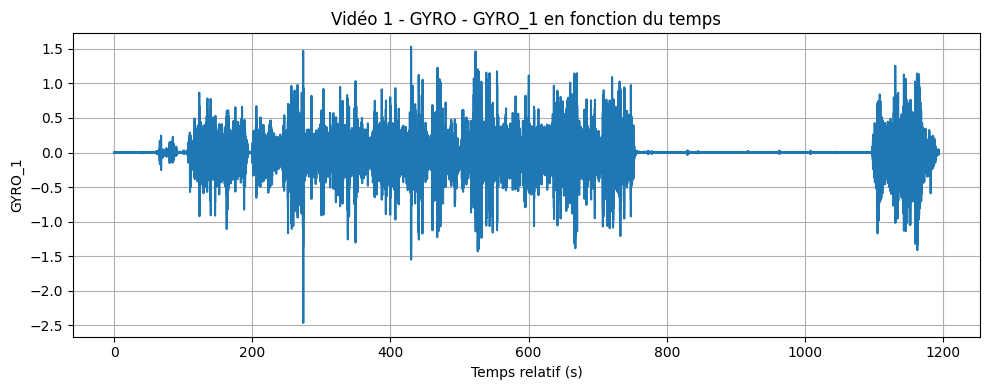

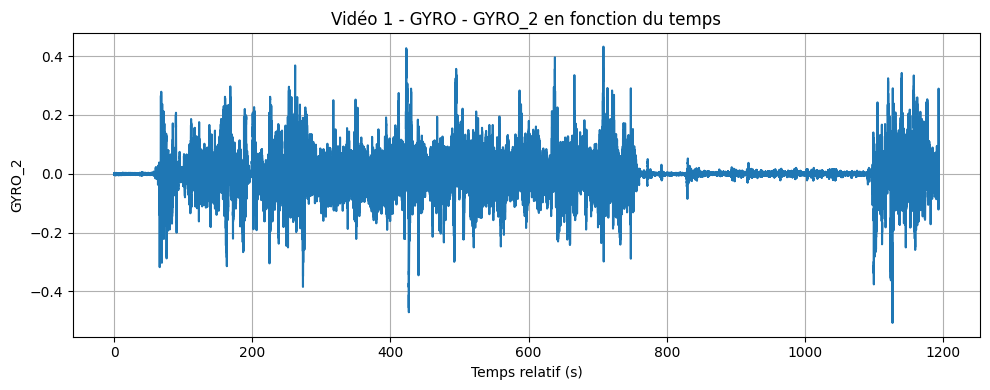

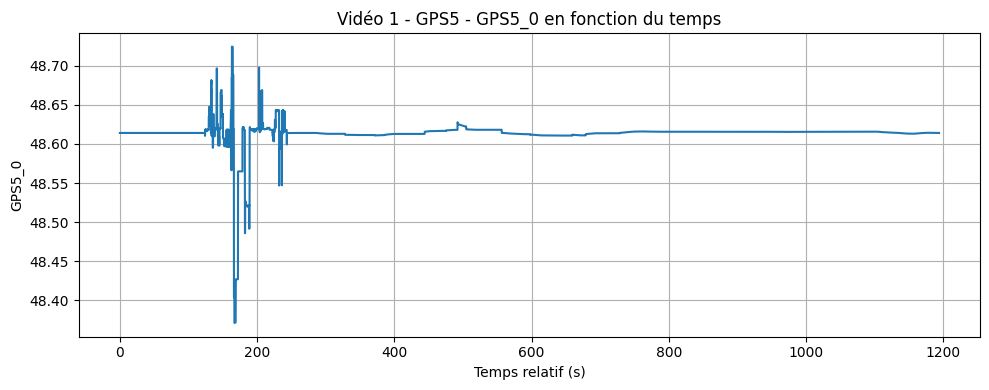

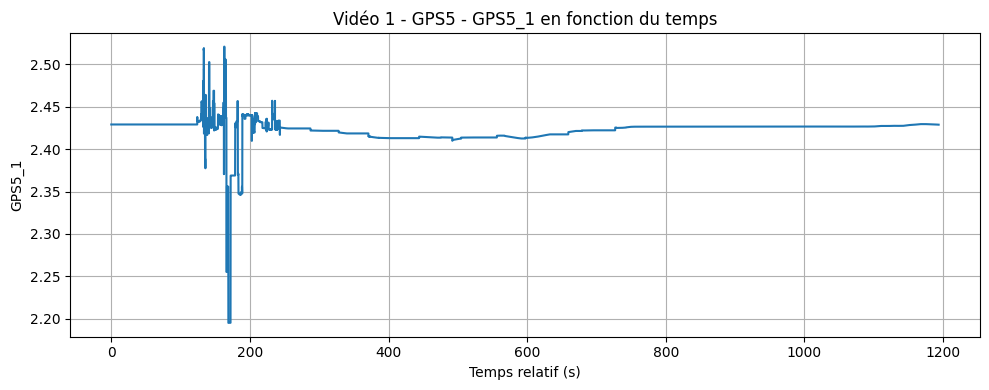

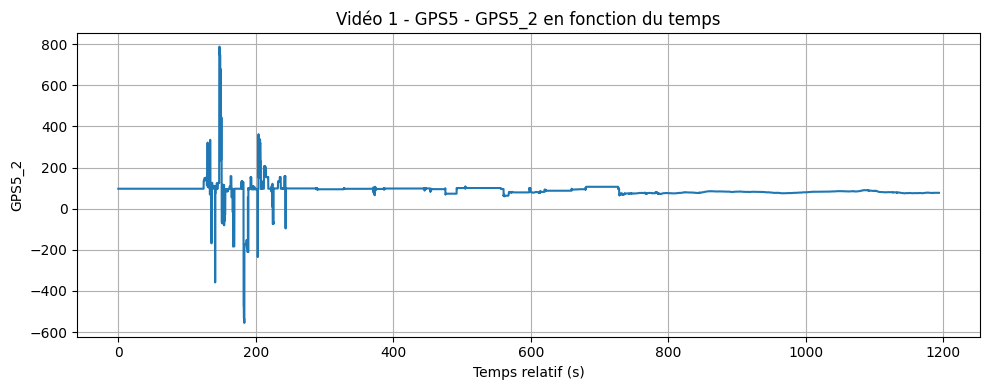

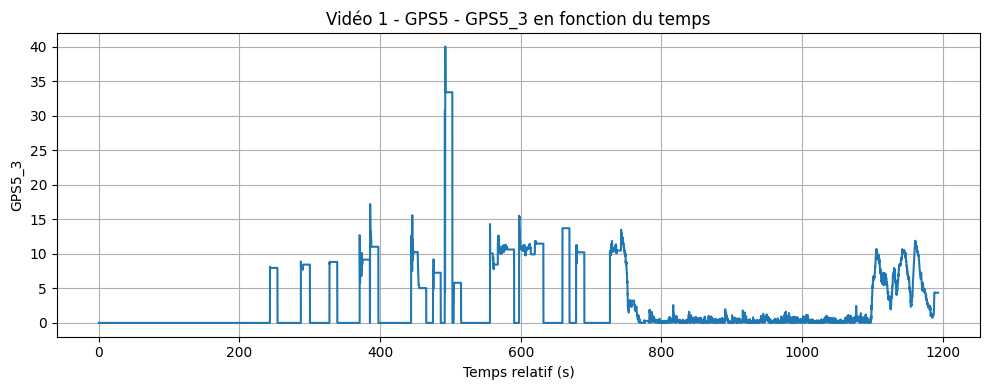

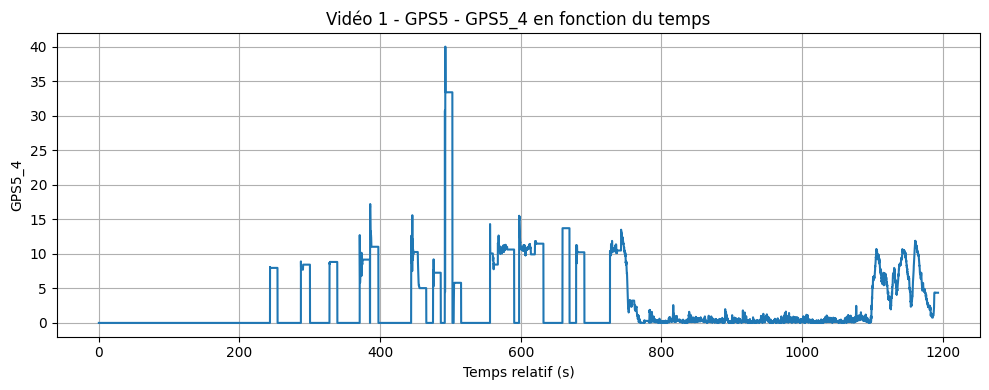

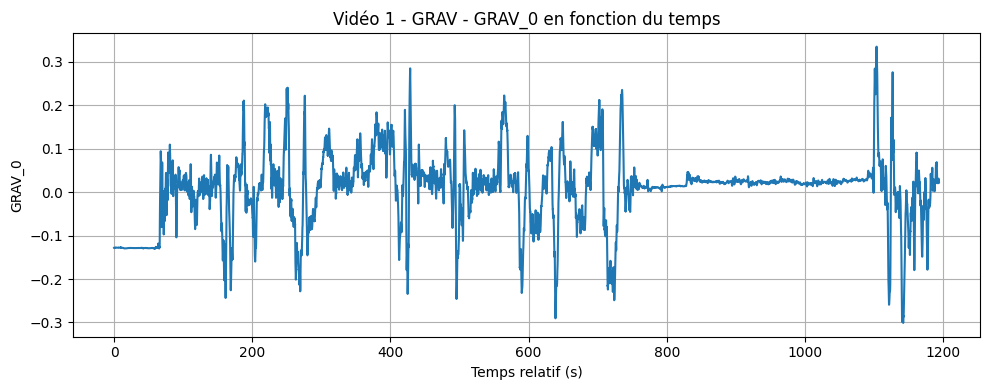

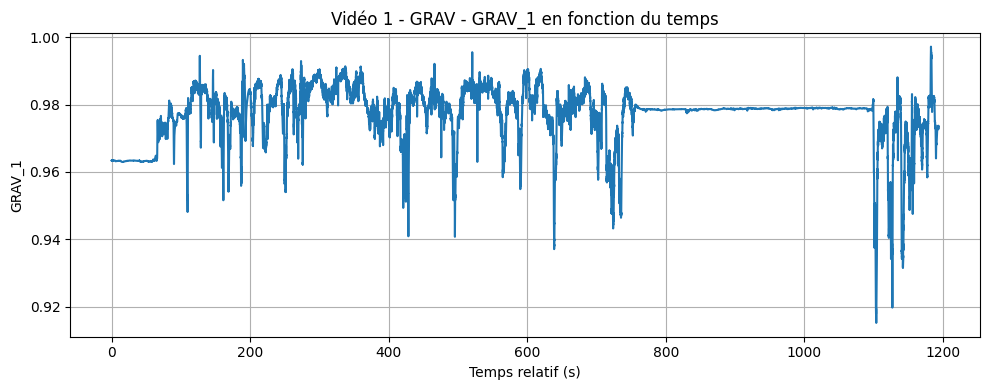

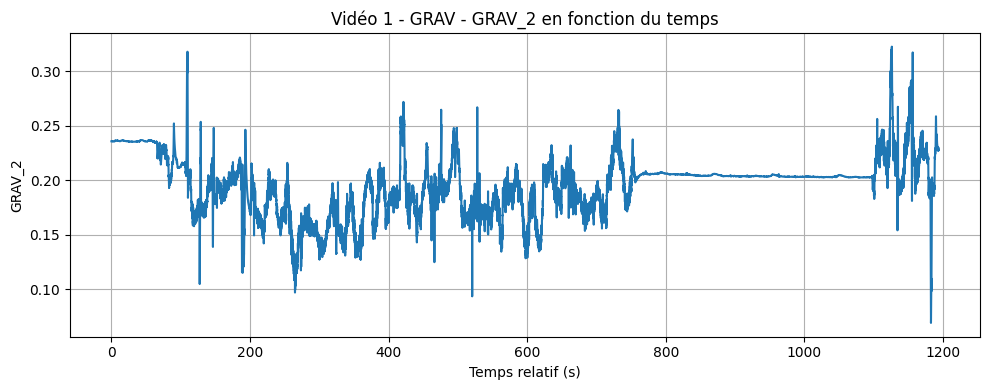

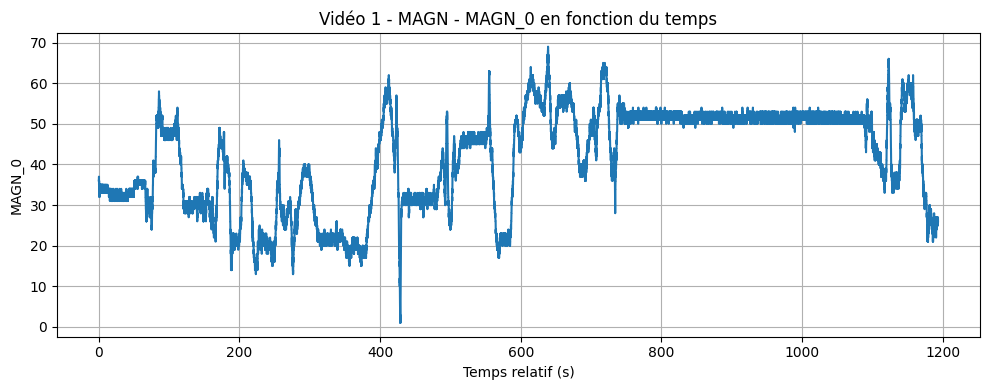

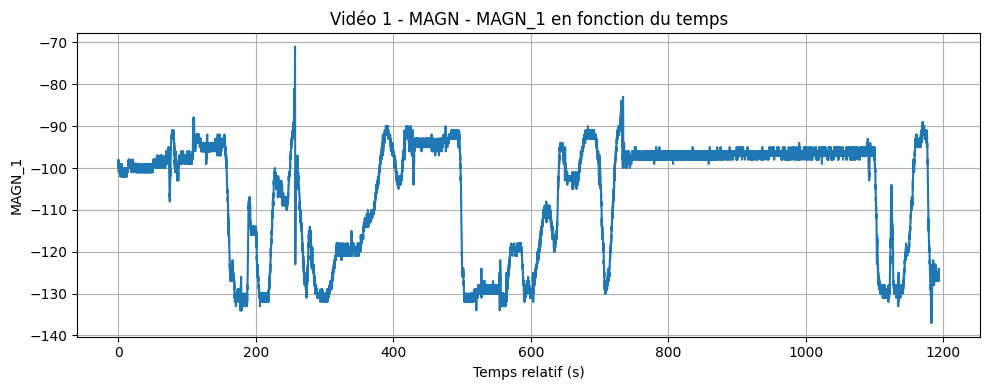

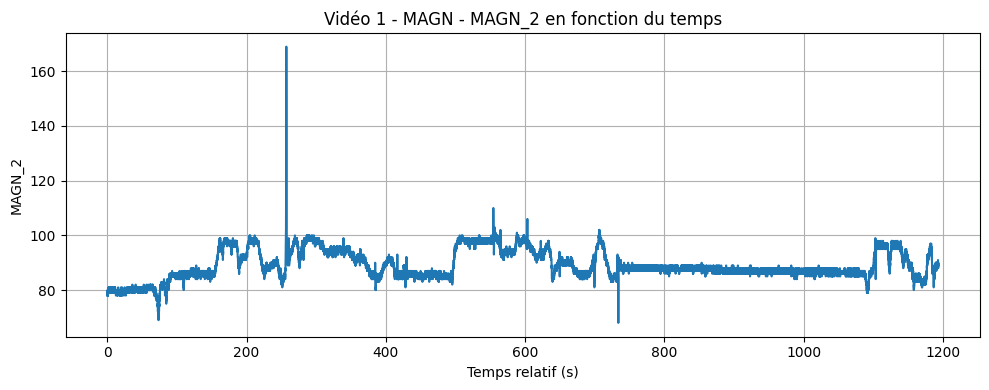

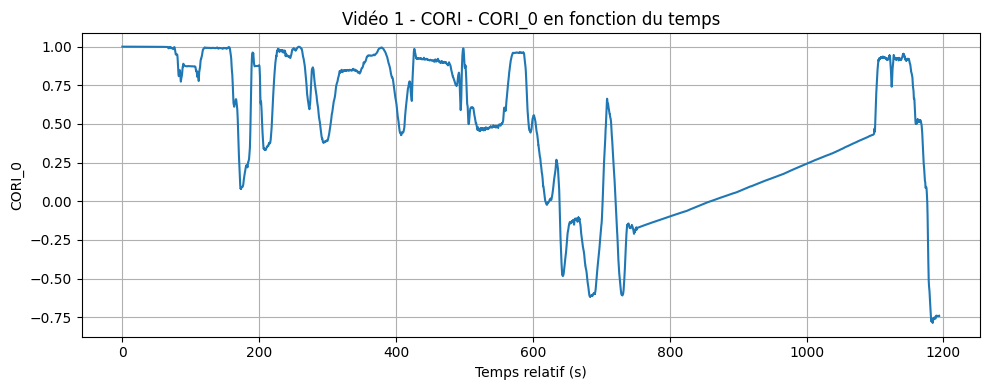

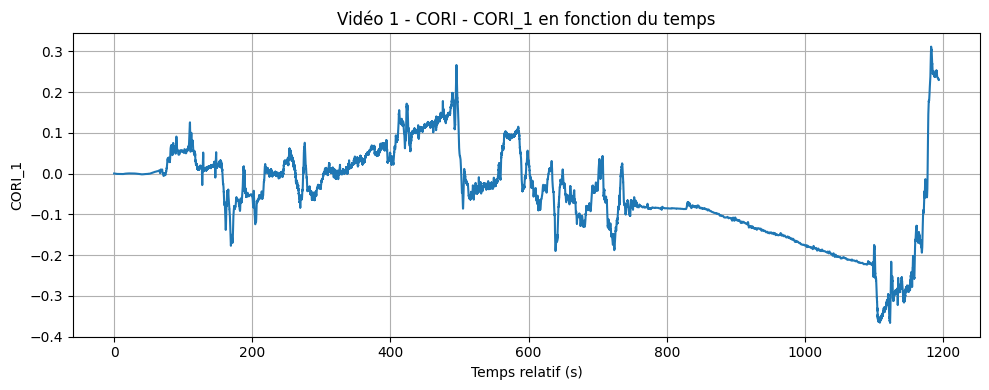

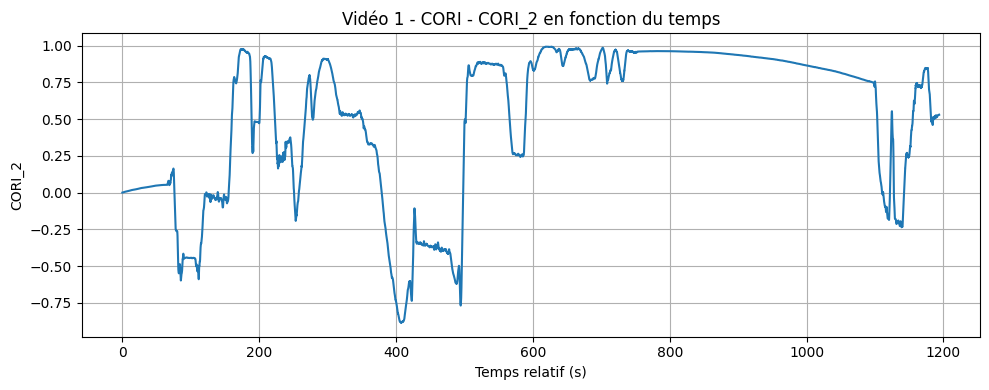

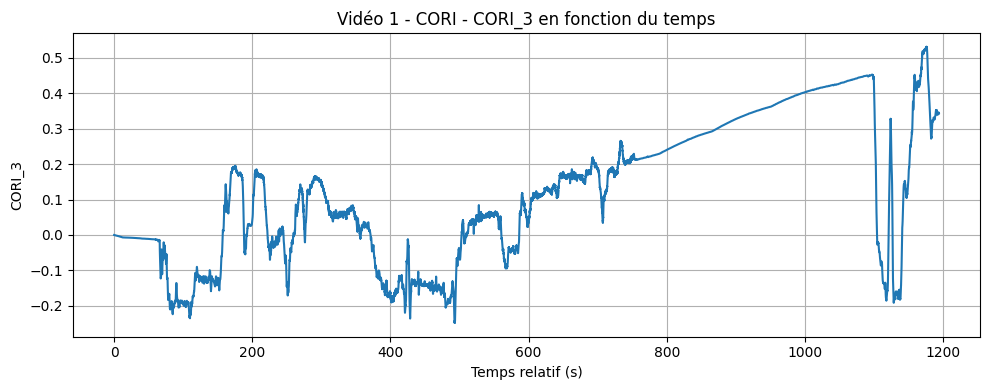

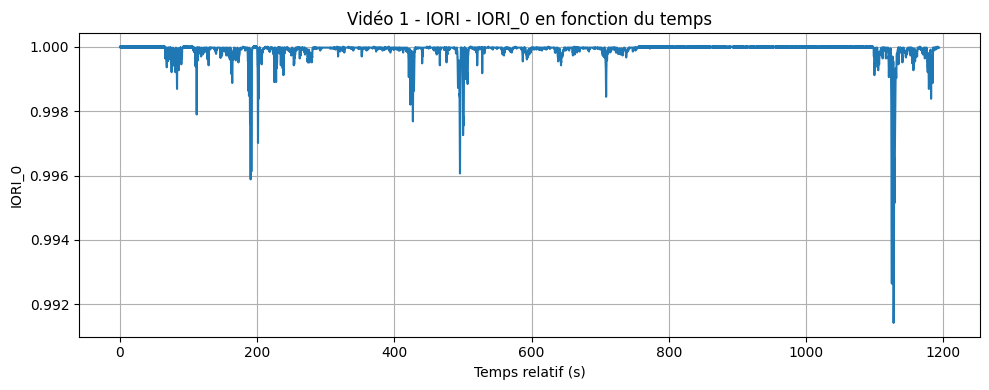

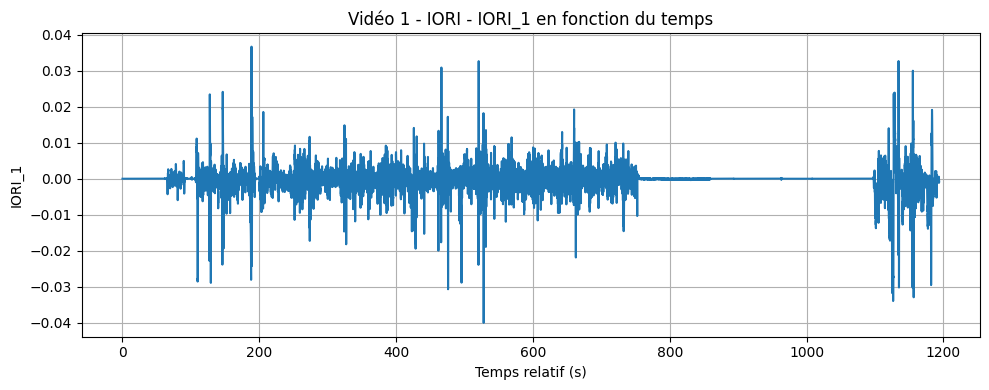

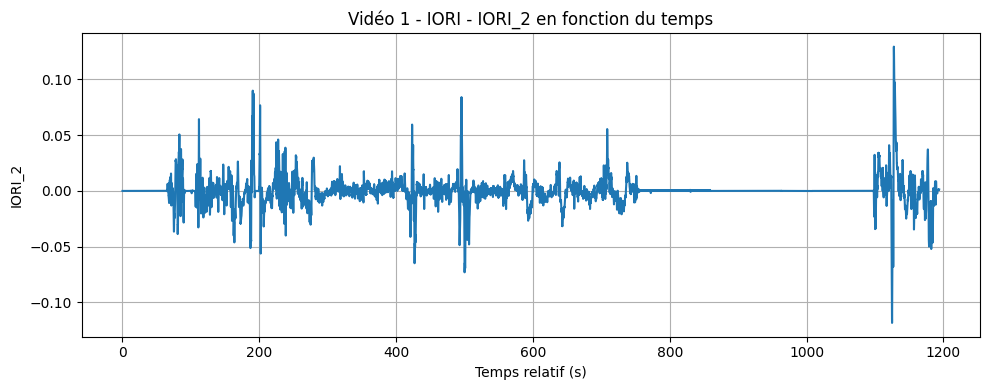

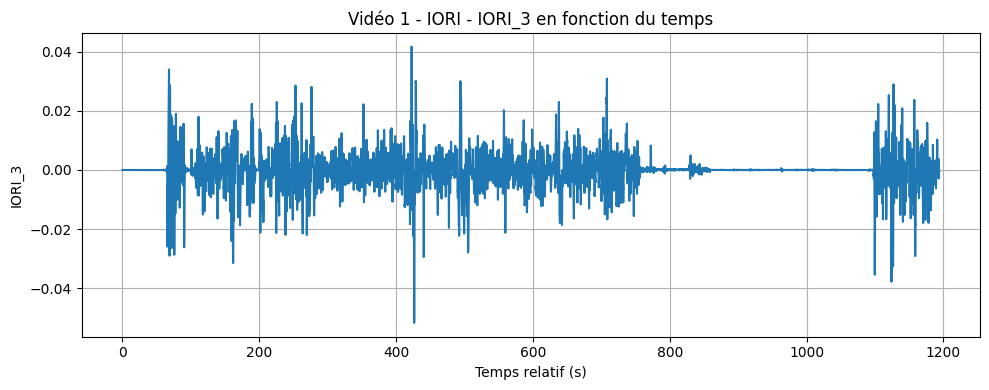

Video 2 DataFrames: ----------------------------------------------------------------------------------------------------


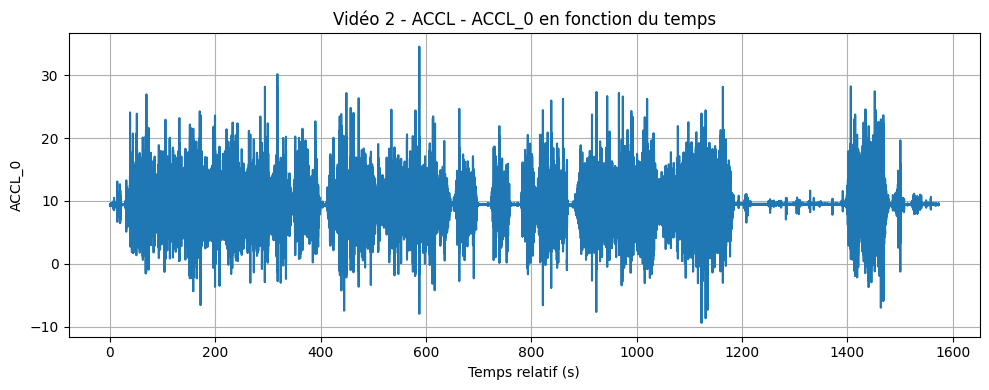

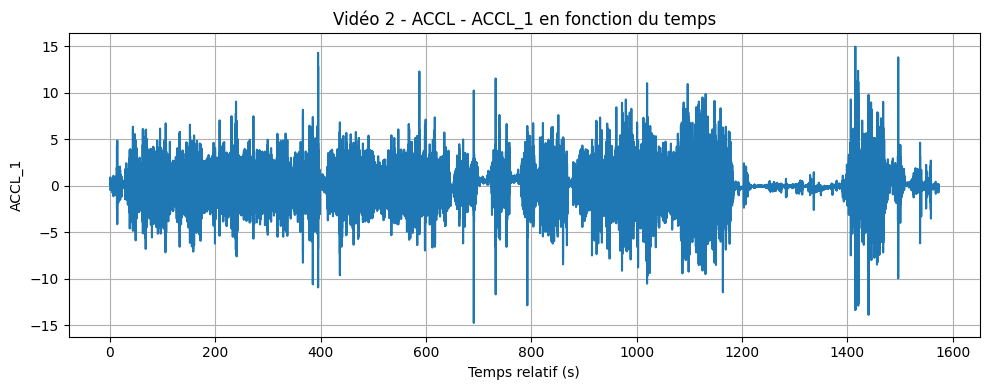

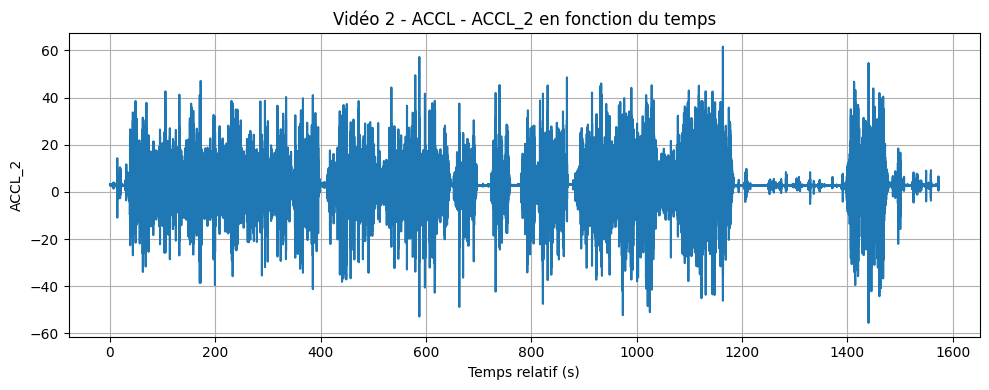

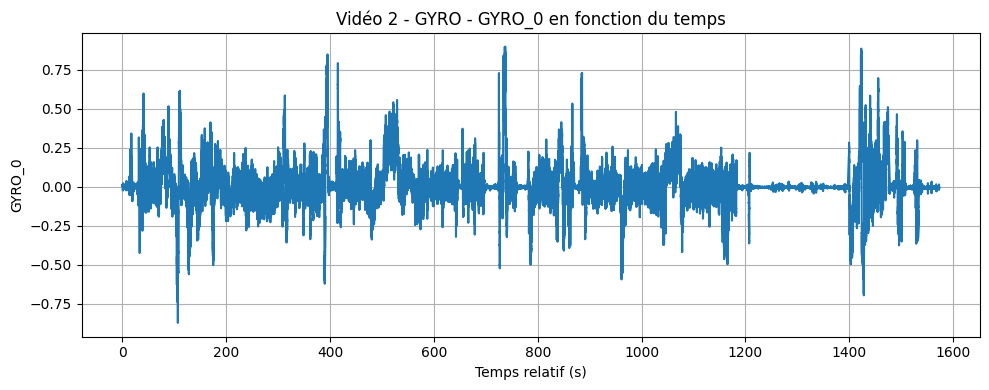

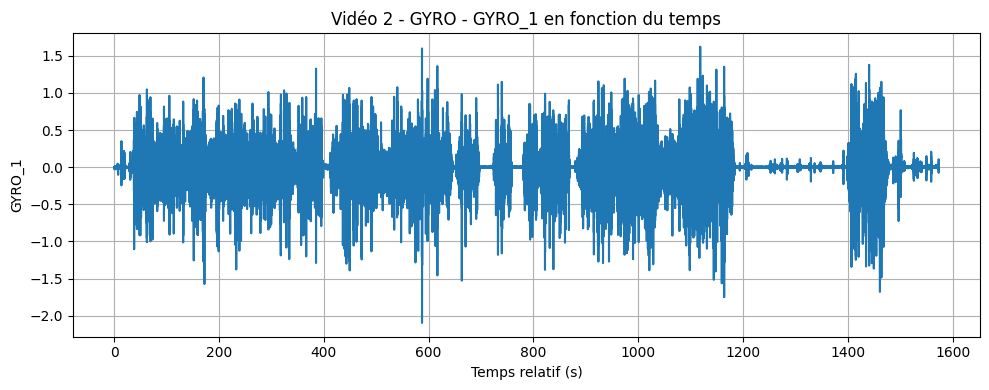

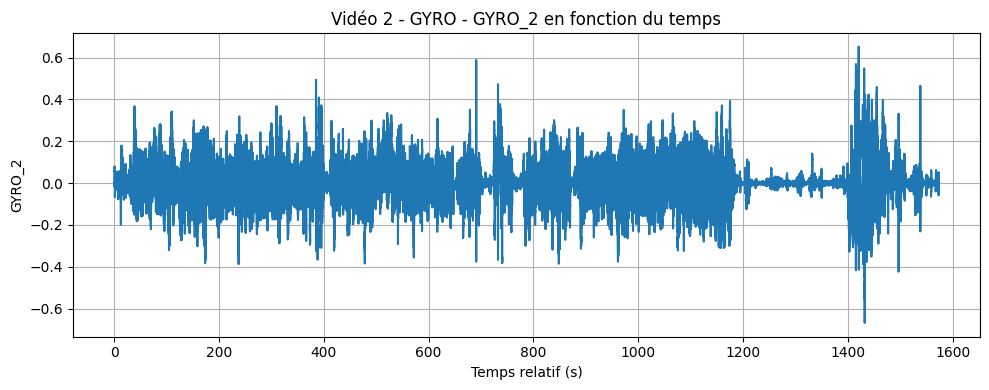

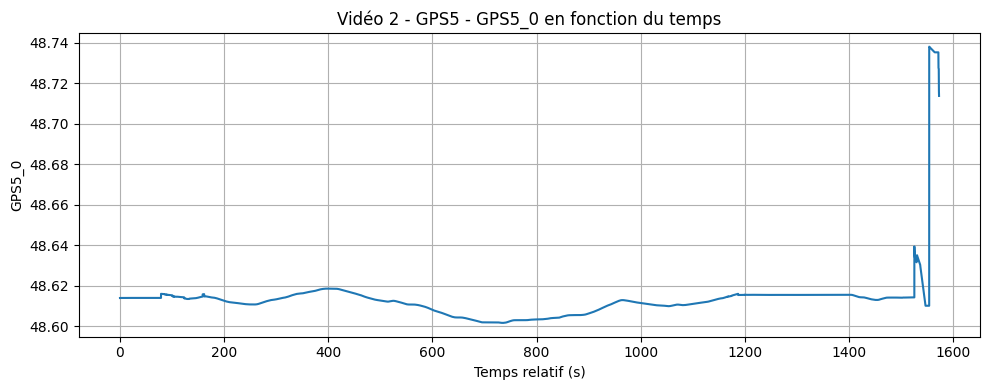

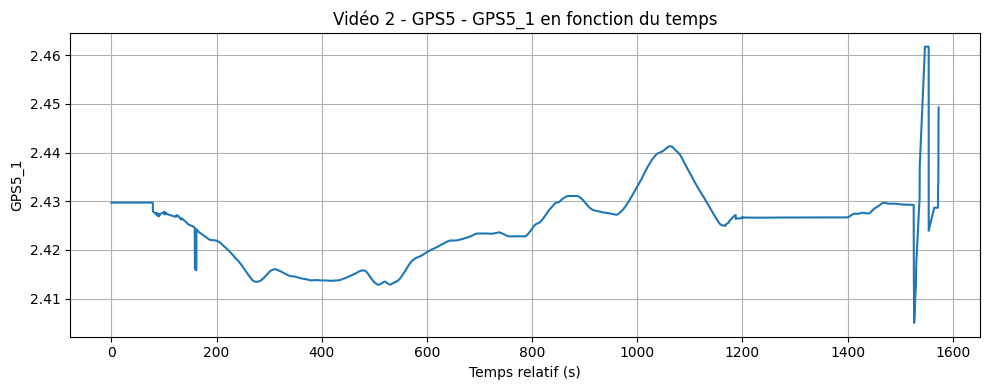

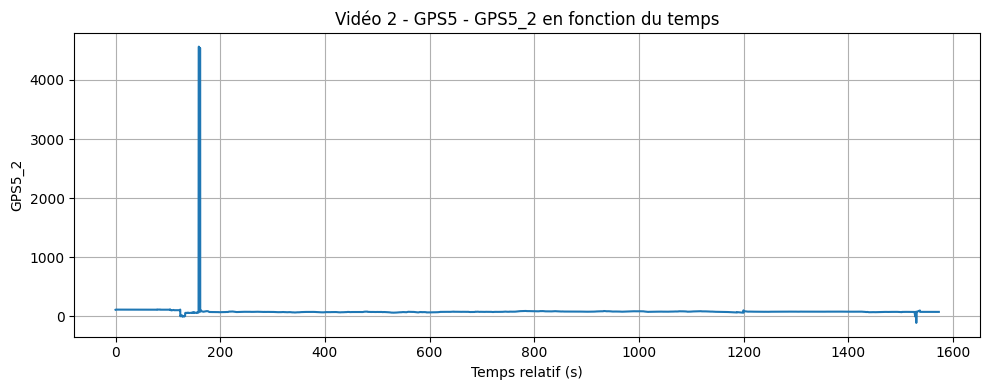

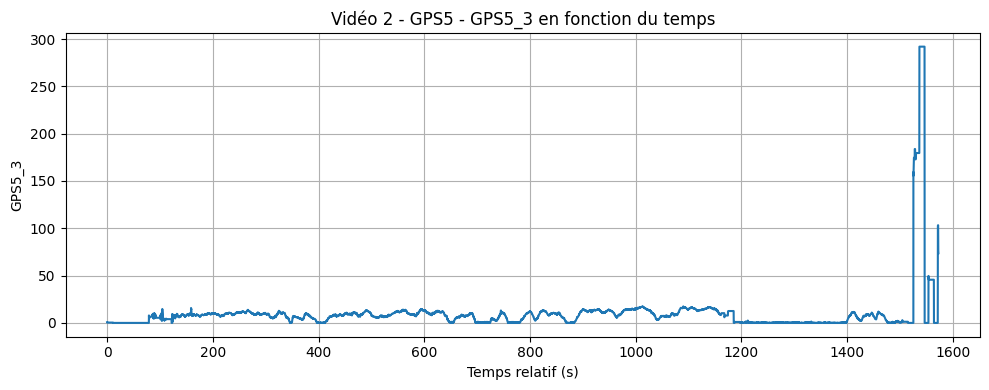

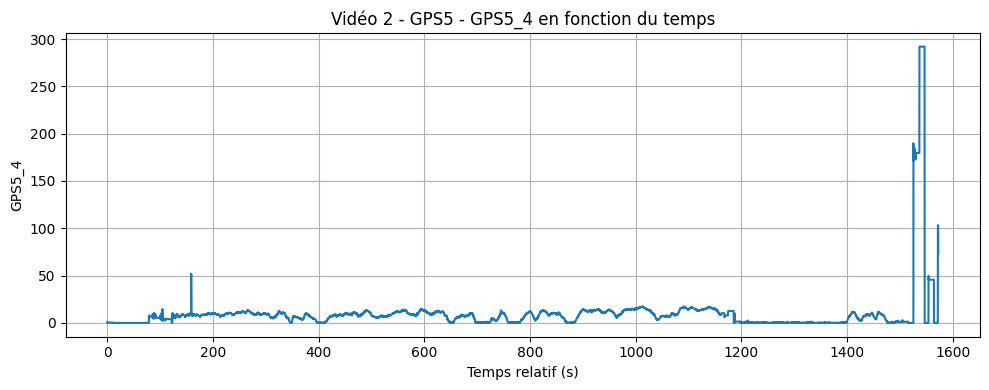

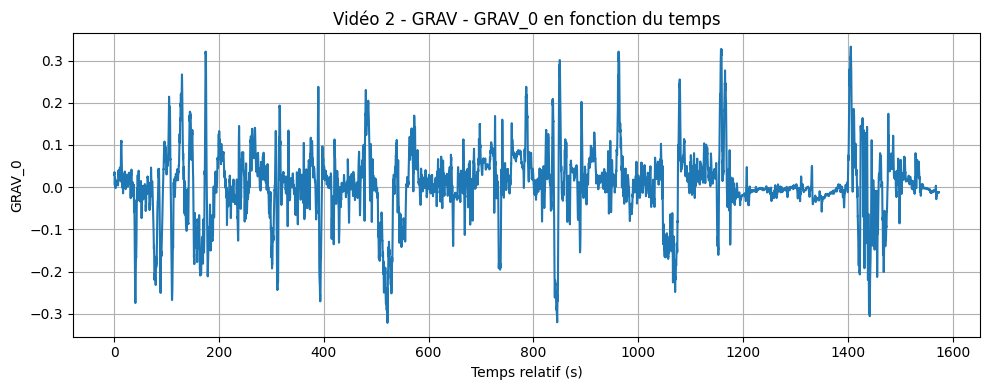

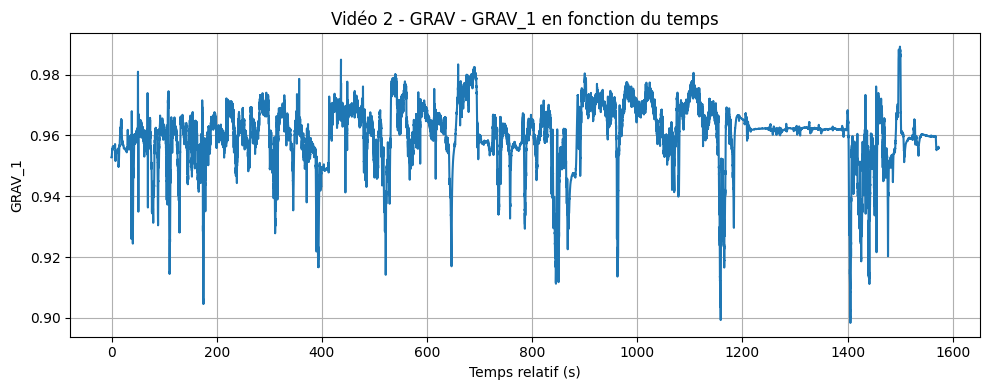

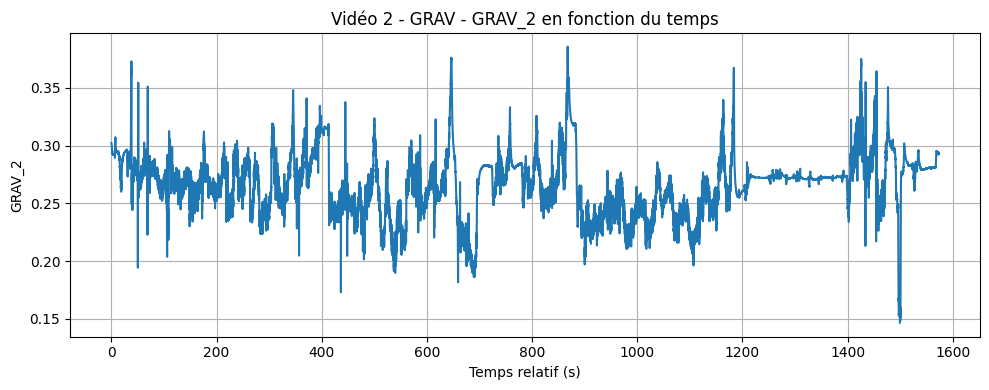

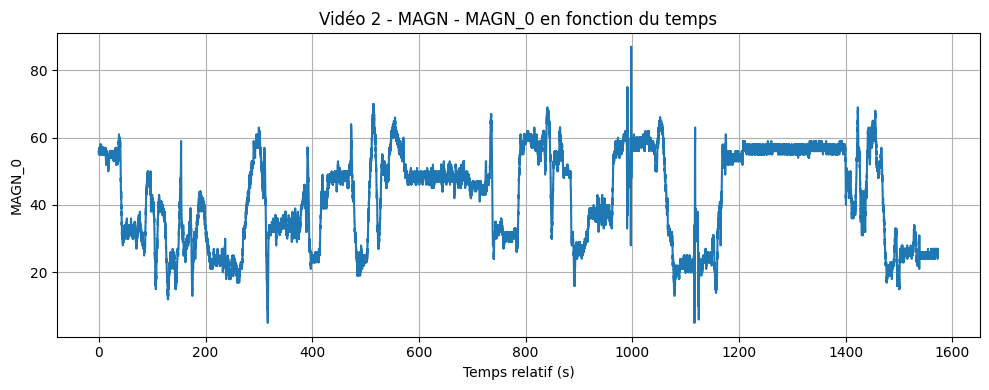

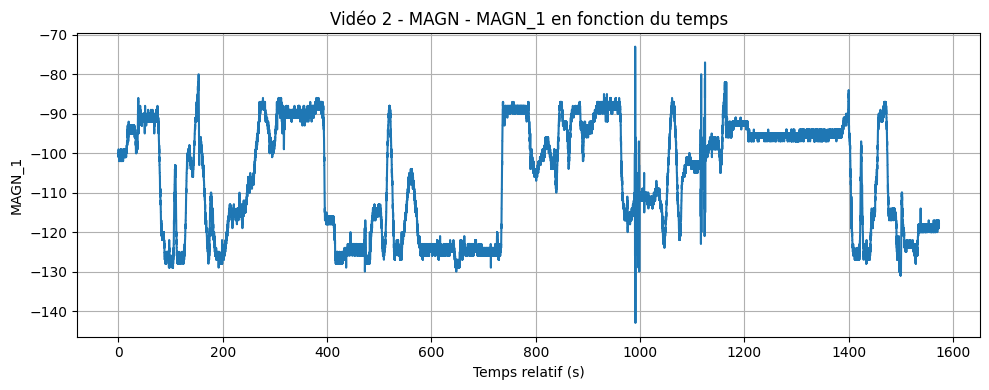

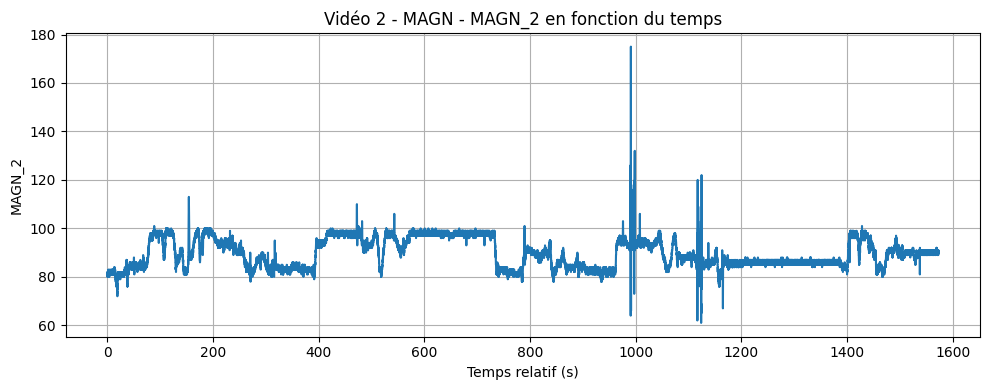

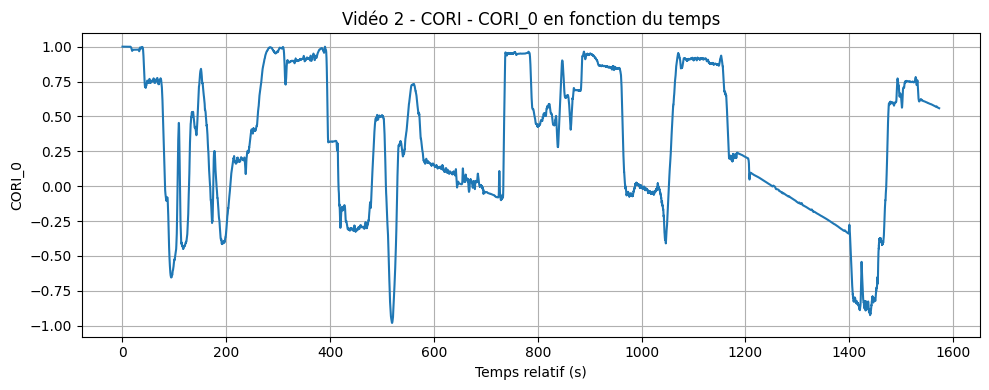

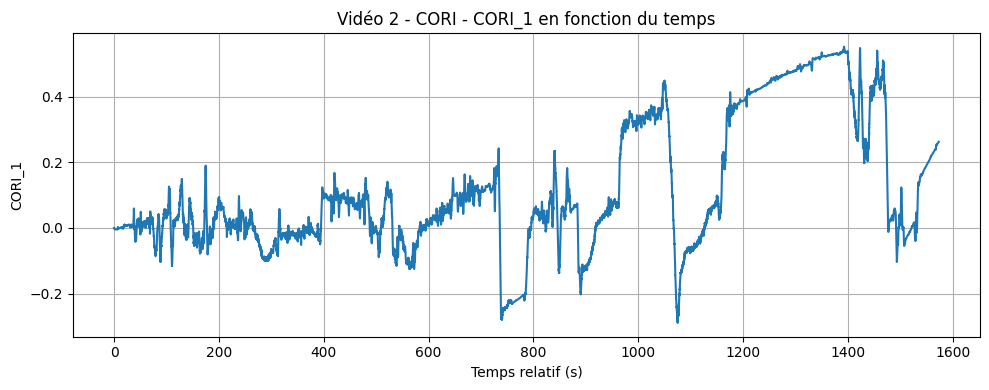

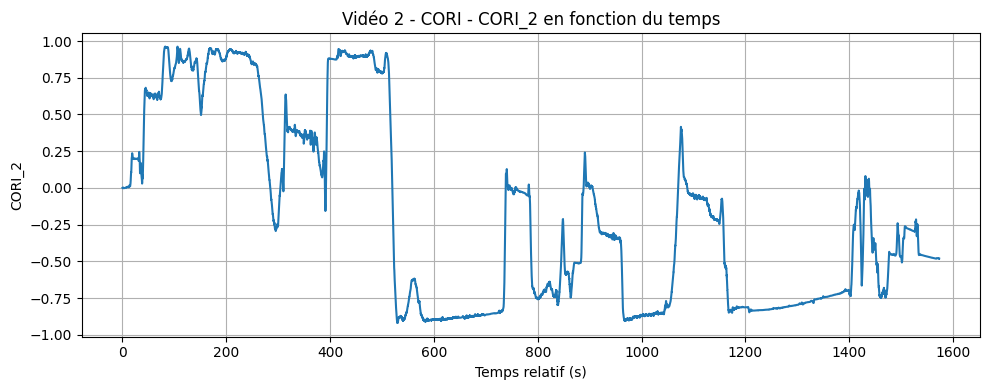

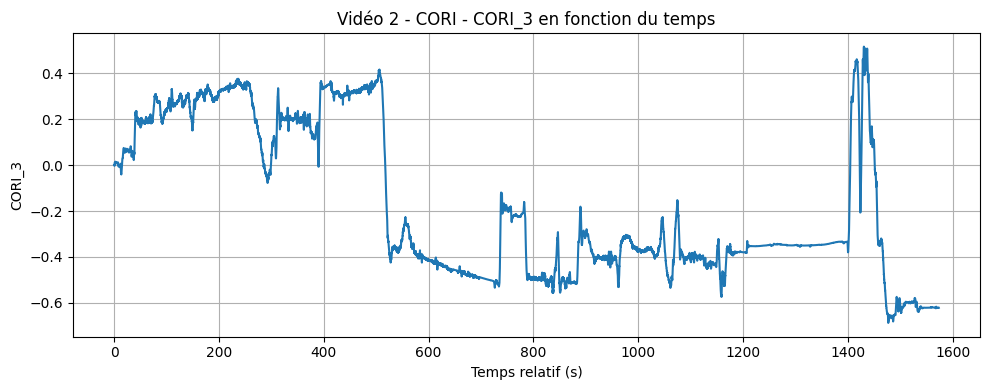

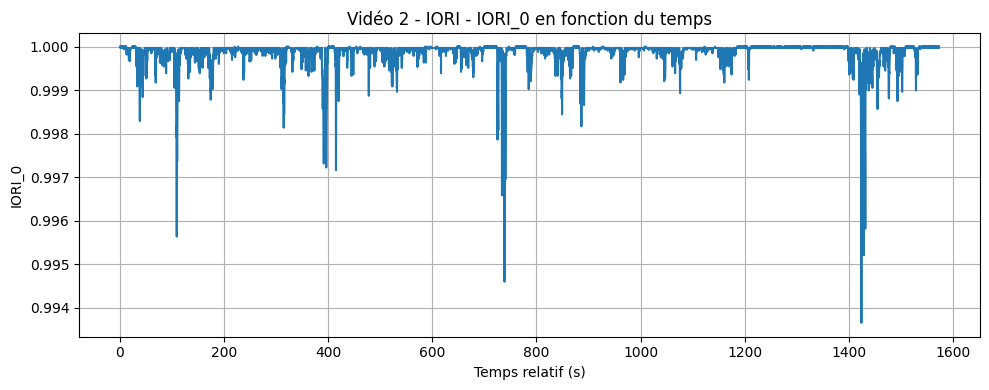

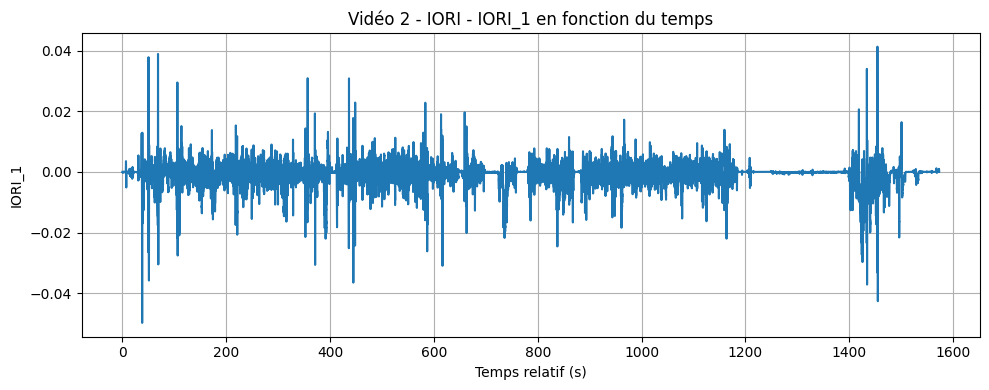

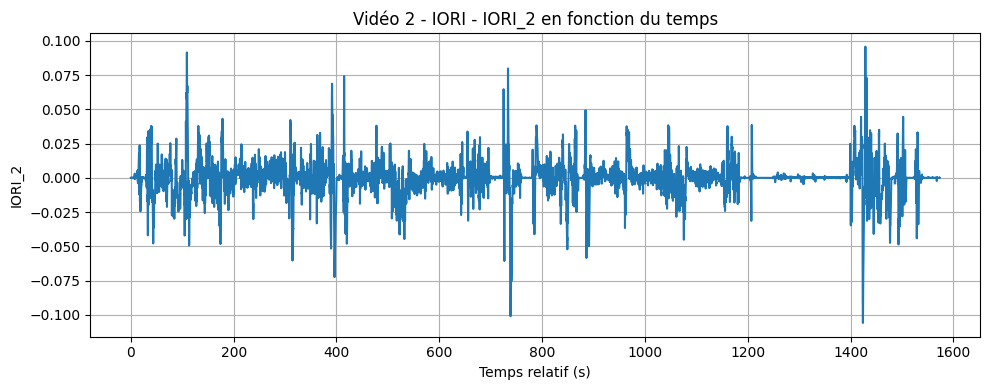

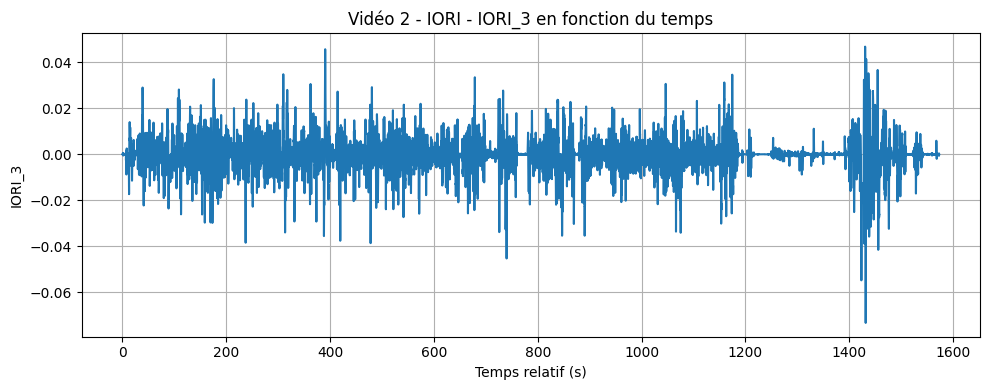

In [58]:
# Plot sensor data for each video
print("Video 1 DataFrames:", "-" * 100)
plot_sensor_data(dfs_video_1, label_prefix="Vidéo 1 - ")
print("Video 2 DataFrames:", "-" * 100)
plot_sensor_data(dfs_video_2, label_prefix="Vidéo 2 - ")

The acceleration data is consistent with the observation of the video, which indicates that the data processing was successful. The moments when the camera is stationary, as the `ACCL` acceleration is zero, correspond to the moments when the stabilized orientation `IORO` is at its lowest, indicating that the graphs are consistent with each other.



### Graph analysis
* **Acceleration**: `ACCL_2` corresponds to the forward/backward acceleration of the motorcycle because it is positively non-zero on average, `ACCL_0` to vertical acceleration since its average is close to 10, which matches Earth's acceleration, and `ACCL_1` corresponds to lateral acceleration since it is zero on average, indicating that the road is mostly straight.
* **Gyroscope**: read below
* **GPS**: there are sometimes outlier data points (spikes) that should be removed.
* **Gravity**: `GRAV_1` corresponds to vertical acceleration as it is close to $1\ g$, `GRAV_2` to forward/backward acceleration because it is non-zero and positive, and therefore `GRAV_0` corresponds to lateral acceleration.
* **Magnetic field**: read below

## Comparison with [GoPro Telemetry Extractor](https://goprotelemetryextractor.com/free/)
Let us compare our .json with the ones etracted from the same .MP4 data thanks to the official website and not our python program.

Structure of the .json file from the website: 
```
{
  "1": {
    "streams": {
      "GPS5": {
        "samples": [
          { "value": [...], "cts": ..., ... }
        ]
      }
    }
  }
}

```

In [59]:
import json
from math import sqrt

def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def euclidean_distance(p1, p2):
    return sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def compare_gps5_data(file1, file2, max_points=1000):
    """
    Compare GPS5 data from two JSON files and return a similarity score between 0 and 1.

    Parameters
    ----------
    file1 : str
        Path to the first JSON file. Must contain GPS5["img_timestamps_s"] and GPS5["data"].
    file2 : str
        Path to the second JSON file. Must contain ["1"]["streams"]["GPS5"]["samples"][...]["value"].
    max_points : int
        Maximum number of points to compare.

    Returns
    -------
    float
        Similarity score between 0 (very different) and 1 (very similar).
    """
    data1 = load_json(file1)
    data2 = load_json(file2)

    gps1 = data1.get("GPS5", {})
    values_1 = gps1.get("data", [])

    samples = data2.get("1", {}).get("streams", {}).get("GPS5", {}).get("samples", [])
    values_2 = [s["value"] for s in samples]

    n = min(len(values_1), len(values_2), max_points)
    if (len(values_1) != len(values_2)):
        print(f"Warning: Different number of GPS5 points in files: {len(values_1)} vs {len(values_2)}. Using the first {n} points.")
    if n == 0:
        return 0.0

    distances = []
    for i in range(n):
        point1 = values_1[i][:3]  # only lat, lon, alt
        point2 = values_2[i][:3]
        dist = euclidean_distance(point1, point2)
        distances.append(dist)

    max_dist = max(distances) if distances else 1
    normalized = [1 - (d / max_dist) for d in distances]
    return sum(normalized) / len(normalized)

score = compare_gps5_data("../json/GH010025.MP4.json", "../json_from_website/GH010025.MP4_from_website.json")
print(f"GPS5 similarity score: {score:.3f}")


GPS5 similarity score: 0.755


Conclusion: when looking at the data, the one extracted from the website seems very truncated because there are only 415 entries on the examples above. Still the website shows the correct map route when extracting the map and not the .json file.

# Computation of the bike roll, pitch and yaw

## Roll, pitch and yaw
We use various GoPro metadata to compute roll, pitch and yaw then using multiple filter methods to ensure the most precise values.

### Roll, pitch and yaw from gyroscope (from `GYRO` values)
Integration of angular velocity:
```python
roll[i+1]  = roll[i] + gyro_x[i] * Δt
pitch[i+1] = pitch[i] + gyro_y[i] * Δt
yaw[i+1]   = yaw[i] + gyro_z[i] * Δt
```
But these values drift over time (gyroscope bias) from reality because of the small approximation mistakes each time ([source](https://vanhunteradams.com/Pico/ReactionWheel/))

In [60]:
def integrate_gyro_orientation_from_dict(dfs, time_col='time_rel'):
    """
    Compute orientation angles (in degrees) by integrating gyroscope angular velocities.

    Parameters
    ----------
    dfs : dict of pd.DataFrame
        Dictionary where each key corresponds to a sensor name (e.g., 'GYRO', 'ACCL'),
        and each value is a DataFrame with time and sensor measurements.
        The 'GYRO' DataFrame must contain columns: 'GYRO_0', 'GYRO_1', 'GYRO_2' in rad/s.

    time_col : str
        Column name representing time in seconds, typically 'time_rel'.

    Returns
    -------
    pd.DataFrame
        A new DataFrame containing time and the integrated orientation angles:
        'Yaw', 'Pitch', 'Roll', corresponding to the three gyroscope axes.
    """
    # Check if the list has en element "GYRO"
    if "GYRO" not in dfs:
        raise ValueError("Missing 'GYRO' data in input dictionary.")

    df_gyro = dfs["GYRO"].copy()

    # Check if all columns are in the DataFrame
    if not all(col in df_gyro.columns for col in ["GYRO_0", "GYRO_1", "GYRO_2", time_col]):
        raise ValueError("The 'GYRO' DataFrame must contain 'GYRO_0', 'GYRO_1', 'GYRO_2' and the specified time column.")

    # Select 3 columns
    gyro = df_gyro[["GYRO_0", "GYRO_1", "GYRO_2"]].values
    # Select 1 column
    time = df_gyro[time_col].values

    # Computes the difference between each consecutive value
    dt = np.diff(time, prepend=time[0])

    orientation = np.zeros_like(gyro)

    # Computes each value
    for i in range(1, len(gyro)):
        orientation[i] = orientation[i - 1] + gyro[i] * dt[i]

    # Copies the value of the first row in the second for more continuity
    orientation[0] = orientation[1]

    # Convert rad to degrees
    orientation_deg = np.degrees(orientation)

    df_orientation = pd.DataFrame({
        time_col: time,
        "roll": orientation_deg[:, 2], # first column
        "pitch": orientation_deg[:, 1], # second column
        "yaw": orientation_deg[:, 0], # third column
    })

    return df_orientation

roll_pitch_yaw_gyro_1 = integrate_gyro_orientation_from_dict(dfs_video_1)
roll_pitch_yaw_gyro_2 = integrate_gyro_orientation_from_dict(dfs_video_2)

After analysing the video with the graph on the side, `GYRO_0` seems to be yaw. Indeed, when looking at the right and left turns to the video, they match the graph values in degrees.

`GYRO_2` seems to correspond to roll as the change in the change in yaw related to turning left or right correspond to the change of `GYRO_2` thus matching the graph shape. When then bike is turning it is also swinging thus leading to changes in roll.

Thus `GYRO_1` is pitch and the graph shape is mainly small integration mistakes picked along the video (see below).

It is worth noting that the drift appears clear thoughout the video as values drift up to more than 600 degrees while it is clear in the video that all except yaw must be equal to 0 at the end!

Let us display the data.

Video 1: ----------------------------------------------------------------------------------------------------


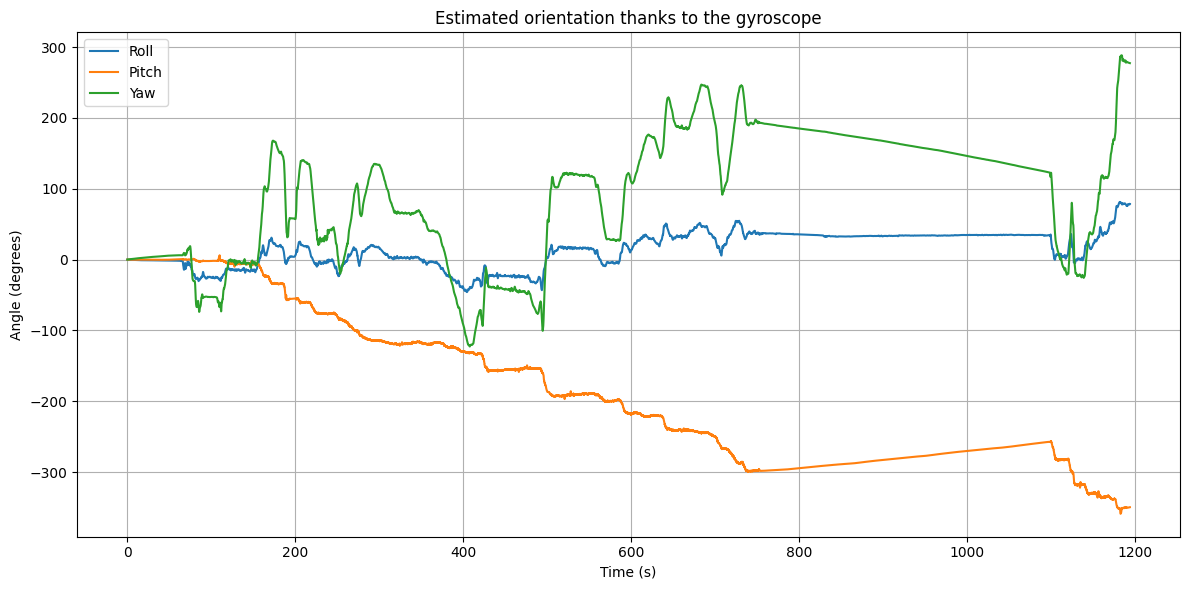

Video 2: ----------------------------------------------------------------------------------------------------


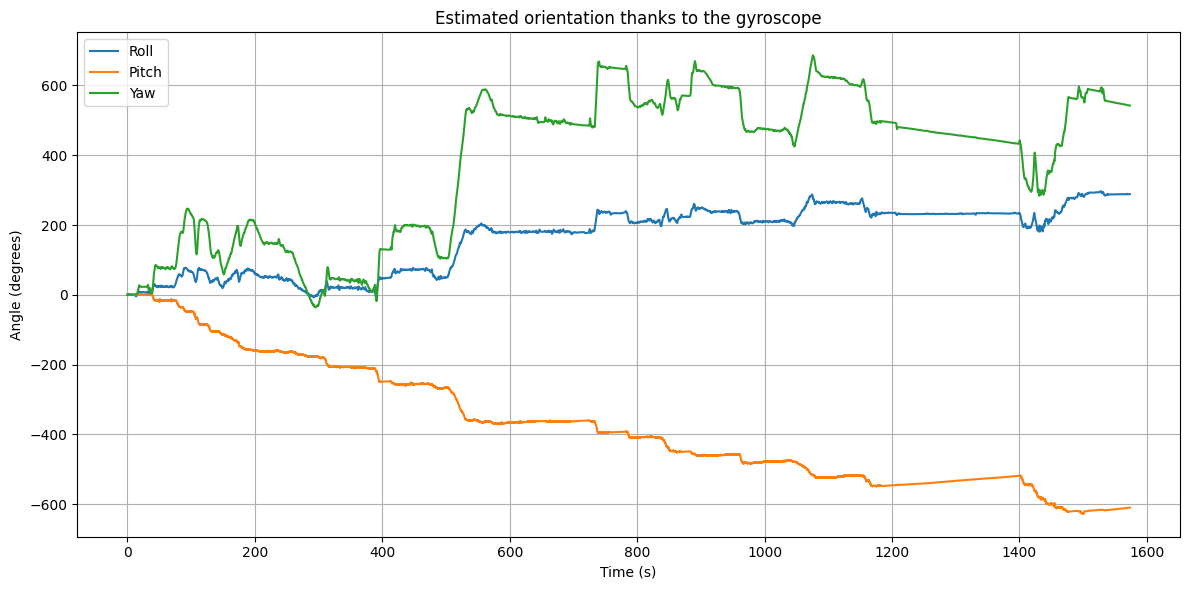

In [61]:
def display_df(df_orientation, time_col="time_rel"):
    """
    Plot roll, pitch, yaw (Yaw, Pitch, Roll) over time.

    Parameters
    ----------
    df_orientation : pd.DataFrame
        DataFrame containing orientation columns: 'roll', 'pitch', 'yaw', and a time column.

    time_col : str
        Name of the time column, typically 'time_rel'.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df_orientation[time_col], df_orientation["roll"], label="Roll")
    plt.plot(df_orientation[time_col], df_orientation["pitch"], label="Pitch")
    plt.plot(df_orientation[time_col], df_orientation["yaw"], label="Yaw")
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title("Estimated orientation thanks to the gyroscope")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Video 1:", "-" * 100)
display_df(roll_pitch_yaw_gyro_1)
print("Video 2:", "-" * 100)
display_df(roll_pitch_yaw_gyro_2)


### Roll and pitch from accelerometer
Static estimation: because gravity is always down, you can project it on the sensor frame.
```python
roll  = atan2(acc_y, acc_z)
pitch = atan2(-acc_x, sqrt(acc_y**2 + acc_z**2))
```
This gives good long-term orientation to correct for the first indicator, but poor during acceleration or vibration. Indeed, if the device is moving, accelerating, or vibrating, the acceleration includes not only motion, shocks, engine vibration, bumps from the vehicle. But in this case the acceleration is at most a few $g$ ([source](https://vanhunteradams.com/Pico/ReactionWheel/)).

As seen before,
* ACCL_0: vertical (gravity-aligned)
* ACCL_1: lateral (side-to-side)
* ACCL_2: longitudinal (forward/backward)

Thus, the roll comes from ACCL_1 vs ACCL_0, and pitch from ACCL_2 vs sqrt(ACCL_1² + ACCL_0²).

In [62]:
def estimate_orientation_from_accelerometer(dfs, time_col="time_rel"):
    """
    Estimate roll and pitch from accelerometer using static orientation formulas.

    Assumes that the only acceleration is due to gravity (i.e., no motion or vibration).
    Yaw cannot be estimated from the accelerometer alone.

    Parameters
    ----------
    dfs : dict of pd.DataFrame
        Dictionary containing sensor data. Must include 'ACCL' key with a DataFrame
        containing accelerometer columns: 'ACCL_0', 'ACCL_1', 'ACCL_2' (in m/s² or g),
        and a time column.

    time_col : str
        Name of the time column, typically 'time_rel'.

    Returns
    -------
    pd.DataFrame
        DataFrame with time and estimated 'roll_accel' and 'pitch_accel' in degrees.
    """
    if "ACCL" not in dfs:
        raise ValueError("Missing 'ACCL' data in input dictionary.")

    df_acc = dfs["ACCL"].copy()

    if not all(col in df_acc.columns for col in ["ACCL_0", "ACCL_1", "ACCL_2", time_col]):
        raise ValueError("The 'ACCL' DataFrame must contain 'ACCL_0', 'ACCL_1', 'ACCL_2' and the specified time column.")

    acc_vert = df_acc["ACCL_0"].values      # vertical
    acc_lat = df_acc["ACCL_1"].values       # lateral
    acc_long = df_acc["ACCL_2"].values      # forward/backward

    # Static estimation using gravity direction
    roll = np.arctan2(acc_lat, acc_vert)
    pitch = np.arctan2(-acc_long, np.sqrt(acc_lat**2 + acc_vert**2))

    # Convert to degrees
    roll_deg = np.degrees(roll)
    pitch_deg = np.degrees(pitch)

    # Set the first value to be equal to the second (copy)
    acc_vert[0] = acc_vert[1]
    acc_lat[0] = acc_lat[1]
    acc_long[0] = acc_long[1]

    return pd.DataFrame({
        time_col: df_acc[time_col],
        "roll_accl": roll_deg,
        "pitch_accl": pitch_deg
    })

roll_pitch_acc_1 = estimate_orientation_from_accelerometer(dfs_video_1)
roll_pitch_acc_2 = estimate_orientation_from_accelerometer(dfs_video_2)

Video 1: ----------------------------------------------------------------------------------------------------


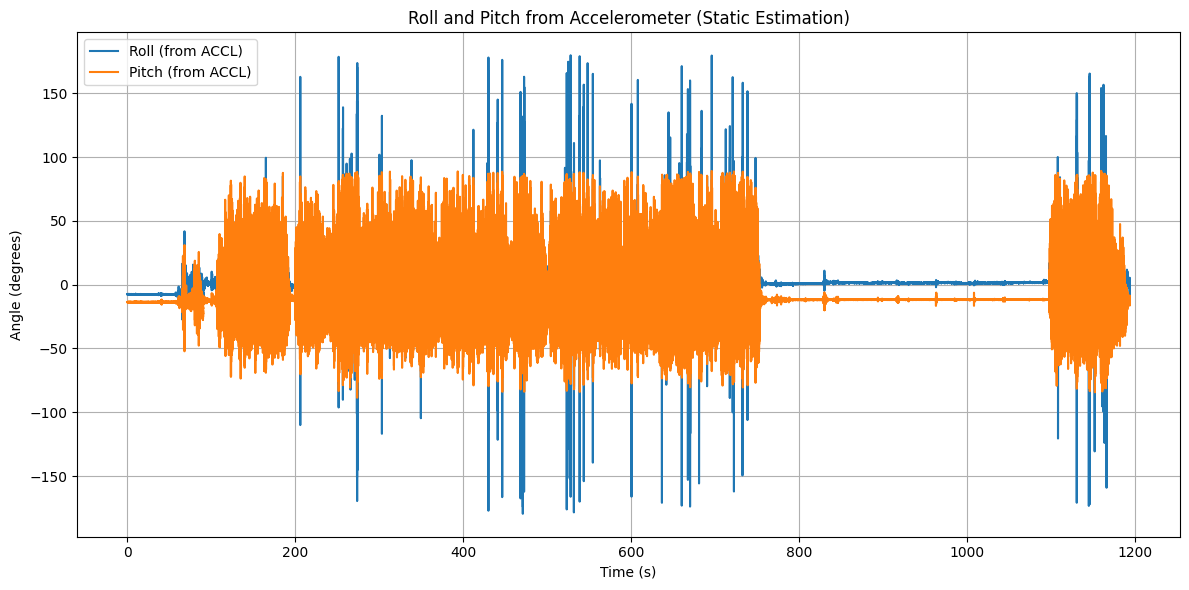

Video 2: ----------------------------------------------------------------------------------------------------


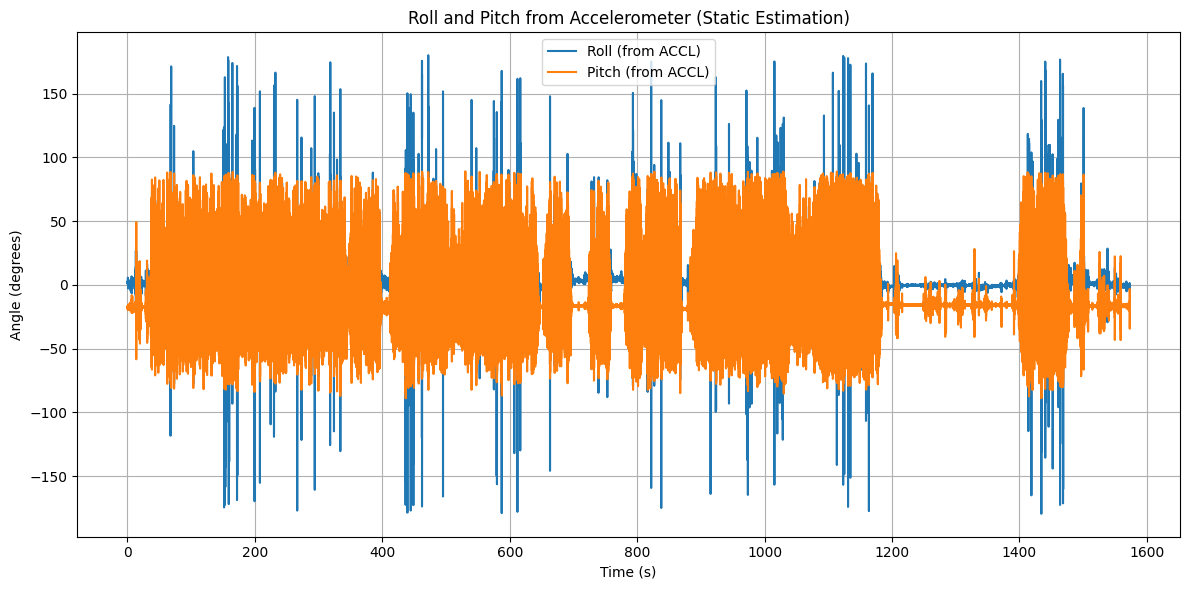

In [63]:
def plot_accel_orientation(df_accel_orientation, time_col="time_rel"):
    """
    Plot roll and pitch angles estimated from accelerometer data.

    Parameters
    ----------
    df_accel_orientation : pd.DataFrame
        DataFrame containing accelerometer-based orientation estimates.
        Must include 'roll_accl', 'pitch_accl', and a time column.

    time_col : str
        Name of the column representing time (default is 'time_rel').
    """
    plt.figure(figsize=(12, 6))

    plt.plot(df_accel_orientation[time_col], df_accel_orientation["roll_accl"], label="Roll (from ACCL)")
    plt.plot(df_accel_orientation[time_col], df_accel_orientation["pitch_accl"], label="Pitch (from ACCL)")

    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title("Roll and Pitch from Accelerometer (Static Estimation)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Video 1:", "-" * 100)
plot_accel_orientation(roll_pitch_acc_1)
print("Video 2:", "-" * 100)
plot_accel_orientation(roll_pitch_acc_2)

Graph analysis: I guess roll is bigger than pitch in this case as the bike is turning left, it is gaining much more roll than pitch when the bike is speeding or slowing down ?

Note this graph is way more erratic than the precedent because it is picking small changes way stronger but it is more relevant long-term.

### Yaw from compass

In [64]:
def compute_yaw_from_compass(dfs, time_col="time_rel"):
    """
    Compute yaw (heading) from magnetometer data.

    Assumes flat terrain (no tilt compensation). If the device is tilted, this estimate becomes inaccurate.

    Parameters
    ----------
    dfs : dict of pd.DataFrame
        Dictionary containing sensor data. Must include 'MAGN' key with a DataFrame
        containing magnetometer columns: 'MAGN_0', 'MAGN_1', 'MAGN_2' and a time column.

    time_col : str
        Name of the time column (usually 'time_rel').

    Returns
    -------
    pd.DataFrame
        DataFrame with time and estimated 'yaw_magn' (in degrees).
    """
    if "MAGN" not in dfs:
        raise ValueError("Missing 'MAGN' data in input dictionary.")

    df_magn = dfs["MAGN"].copy()

    if not all(col in df_magn.columns for col in ["MAGN_0", "MAGN_1", time_col]):
        raise ValueError("The 'MAGN' DataFrame must contain 'MAGN_0', 'MAGN_1' and the specified time column.")

    magn_x = df_magn["MAGN_0"].values
    magn_y = df_magn["MAGN_1"].values

    # Heading (yaw) in radians
    yaw_rad = np.arctan2(magn_y, magn_x)

    # Convert to degrees and normalize to [0, 360)
    yaw_deg = np.degrees(yaw_rad) % 360

    magn_x[0] = magn_x[1]
    magn_y[0] = magn_y[1]

    return pd.DataFrame({
        time_col: df_magn[time_col],
        "yaw_magn": yaw_deg
    })

yaw_magn_1 = compute_yaw_from_compass(dfs_video_1)
yaw_magn_2 = compute_yaw_from_compass(dfs_video_2)

Video 1: ----------------------------------------------------------------------------------------------------


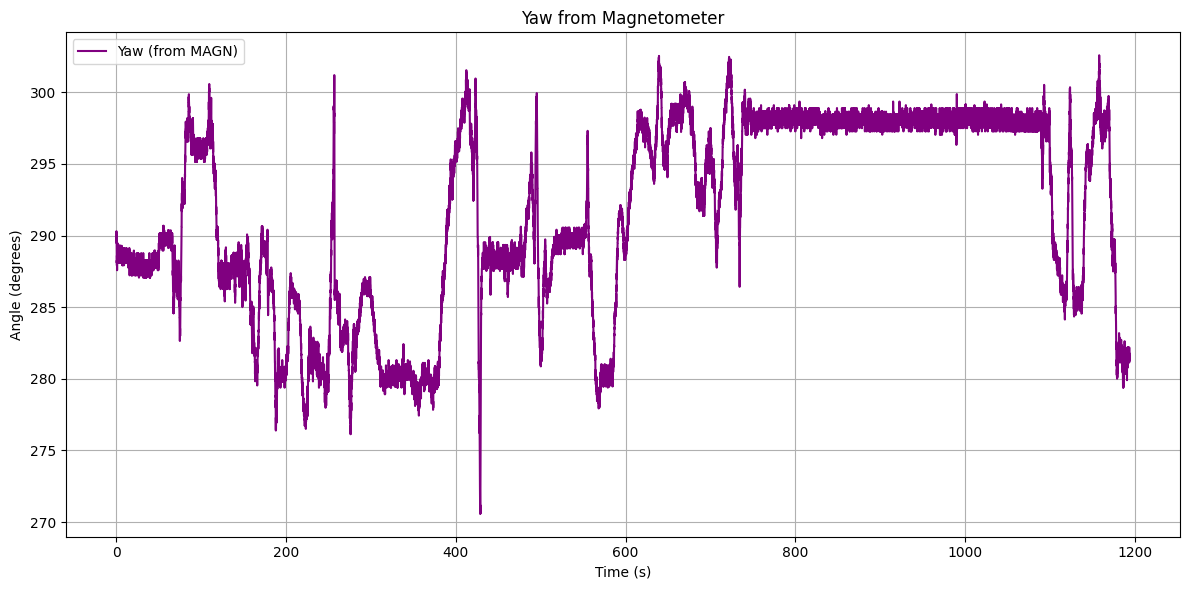

Video 2: ----------------------------------------------------------------------------------------------------


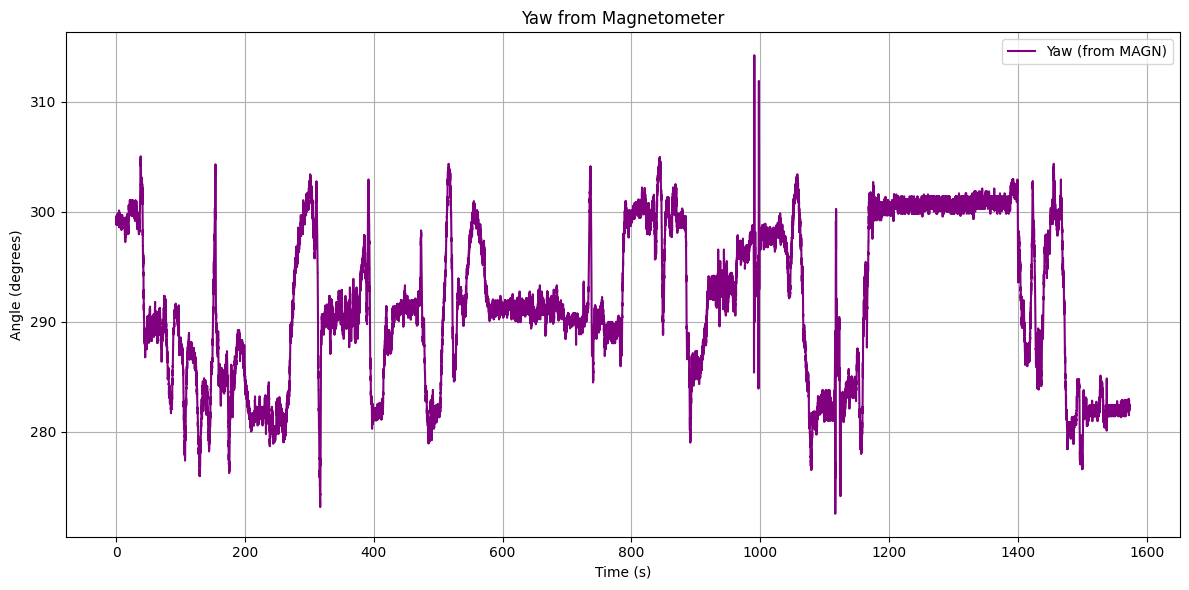

In [65]:
def plot_yaw_from_magnetometer(df, time_col="time_rel", yaw_col="yaw_magn"):
    """
    Plot yaw angle over time as estimated from magnetometer data.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing yaw angle and time columns.
    time_col : str
        Column name representing time in seconds (default is "time_rel").
    yaw_col : str
        Column name for yaw angle in degrees (default is "yaw_magn").
    """
    plt.figure(figsize=(12, 6))

    plt.plot(df[time_col], df[yaw_col], label="Yaw (from MAGN)", color="purple")

    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title("Yaw from Magnetometer")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Video 1:", "-" * 100)
plot_yaw_from_magnetometer(yaw_magn_1)
print("Video 2:", "-" * 100)
plot_yaw_from_magnetometer(yaw_magn_2)

## Filters

### Complentary filter: blend both previous estimates
This method combines the first and second steps.
With `gyro_weight` being a tuning parameter:
```python
roll  = gyro_weight * (roll + gyro_x * Δt) + (1 - gyro_weight) * roll_acc
pitch = gyro_weight * (pitch + gyro_y * Δt) + (1 - gyro_weight) * pitch_acc
```
You get short-term reactivity from the gyroscope, and long-term stability from the accelerometer.

Issue : the magnometer runs at 25 Hz while accelerometer and gyroscope run at 200 Hz.

The following function solves the issue by keeping only rows that have a common `time_rel` column.

In [66]:
def align_erase_df(*dfs, time_col='time_rel'):
    """
    Align multiple DataFrames by keeping only the rows with common time_rel values.

    Parameters
    ----------
    *dfs : pd.DataFrame
        Arbitrary number of DataFrames each with a time_col.
    time_col : str, optional
        Name of the time column (default is 'time_rel').

    Returns
    -------
    list of pd.DataFrame
        List of DataFrames aligned on common time values, with indices reset.
    """
    if not dfs:
        return []

    # Find common time values
    common_times = set(dfs[0][time_col])
    for df in dfs[1:]:
        common_times &= set(df[time_col])

    # Convert to sorted list
    common_times = sorted(common_times)

    # Filter each DataFrame and reset index
    aligned_dfs = [df[df[time_col].isin(common_times)].reset_index(drop=True) for df in dfs]
    
    return aligned_dfs

aligned_roll_pitch_yaw_gyro_1, aligned_roll_pitch_acc_1, aligned_yaw_magn_1 = align_erase_df(roll_pitch_yaw_gyro_1, roll_pitch_acc_1, yaw_magn_1)
aligned_roll_pitch_yaw_gyro_2, aligned_roll_pitch_acc_2, aligned_yaw_magn_2 = align_erase_df(roll_pitch_yaw_gyro_2, roll_pitch_acc_2, yaw_magn_2)

Same here but by interpolating which is better.

In [67]:
def align_and_forward_fill_to_max_timebase(*dfs, time_col='time_rel'):
    """
    Align multiple DataFrames by expanding all to the union of time_rel values,
    and filling missing values using forward fill (last known value).

    Parameters
    ----------
    *dfs : pd.DataFrame
        DataFrames with a time_col to align.
    time_col : str, optional
        Name of the time column (default is 'time_rel').

    Returns
    -------
    list of pd.DataFrame
        List of DataFrames interpolated to the full union of time_rel, forward-filled.
    """
    if not dfs:
        return []

    # Union of all time_rel values
    all_times = sorted(set().union(*(df[time_col] for df in dfs)))

    interpolated_dfs = []
    for df in dfs:
        df = df.copy()

        # Sort by time_col to ensure forward-fill works
        df = df.sort_values(by=time_col)

        # Set time_col as index
        df = df.set_index(time_col)

        # Reindex and forward-fill missing values
        df = df.reindex(all_times)  # reindex to union
        df = df.ffill()  # forward fill
        df = df.reset_index().rename(columns={"index": time_col})  # restore time_col

        interpolated_dfs.append(df)

    return interpolated_dfs

interpolated_roll_pitch_yaw_gyro_1, interpolated_roll_pitch_acc_1, interpolated_yaw_magn_1 = align_and_forward_fill_to_max_timebase(roll_pitch_yaw_gyro_1, roll_pitch_acc_1, yaw_magn_1)
interpolated_roll_pitch_yaw_gyro_2, interpolated_roll_pitch_acc_2, interpolated_yaw_magn_2 = align_and_forward_fill_to_max_timebase(roll_pitch_yaw_gyro_2, roll_pitch_acc_2, yaw_magn_2)

In [68]:
def complementary_filter(gyro_angles, acc_angles, magn_yaw, gyro_weight=0.9):
    """
    Fuse orientation data using a complementary filter.

    Parameters
    ----------
    gyro_angles : pd.DataFrame
        DataFrame with columns ['roll', 'pitch', 'yaw', 'time_rel'].
    acc_angles : pd.DataFrame
        DataFrame with columns ['roll_accl', 'pitch_accl', 'time_rel'].
    magn_yaw : pd.DataFrame
        DataFrame with columns ['yaw_magn', 'time_rel'].
    gyro_weight : float
        Weight for the gyroscope data (0 < gyro_weight < 1).

    Returns
    -------
    pd.DataFrame
        DataFrame with fused 'roll', 'pitch', 'yaw' and 'time_rel'.
    """
    # Interpolate accelerometer and magnetometer to gyro timestamps
    time_base = gyro_angles['time_rel']

    fused = pd.DataFrame({'time_rel': time_base})
    fused['roll'] = gyro_weight * gyro_angles['roll'] + (1 - gyro_weight) * acc_angles ['roll_accl']
    fused['pitch'] = gyro_weight * gyro_angles['pitch'] + (1 - gyro_weight) * acc_angles['pitch_accl']
    fused['yaw'] = gyro_weight * gyro_angles['yaw'] + (1 - gyro_weight) * magn_yaw['yaw_magn']

    return fused

complementary_filter_1 = complementary_filter(interpolated_roll_pitch_yaw_gyro_1, interpolated_roll_pitch_acc_1, interpolated_yaw_magn_1)
complementary_filter_2 = complementary_filter(interpolated_roll_pitch_yaw_gyro_2, interpolated_roll_pitch_acc_2, interpolated_yaw_magn_2)

Video 1: ----------------------------------------------------------------------------------------------------


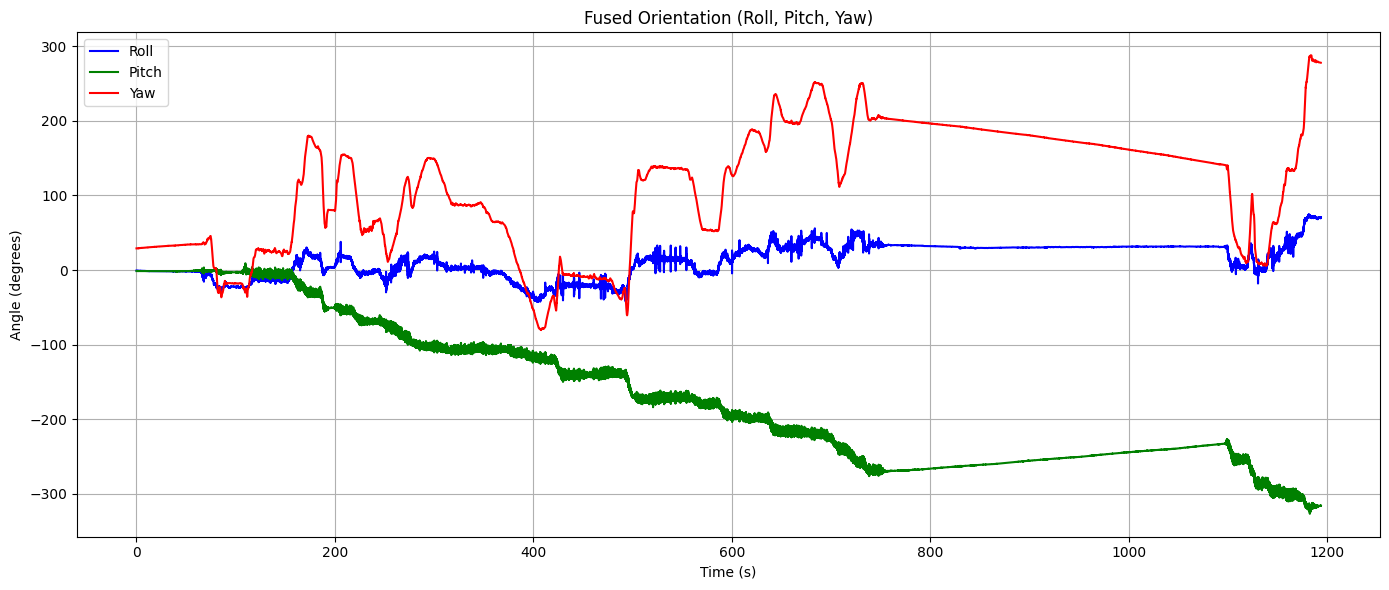

Video 2: ----------------------------------------------------------------------------------------------------


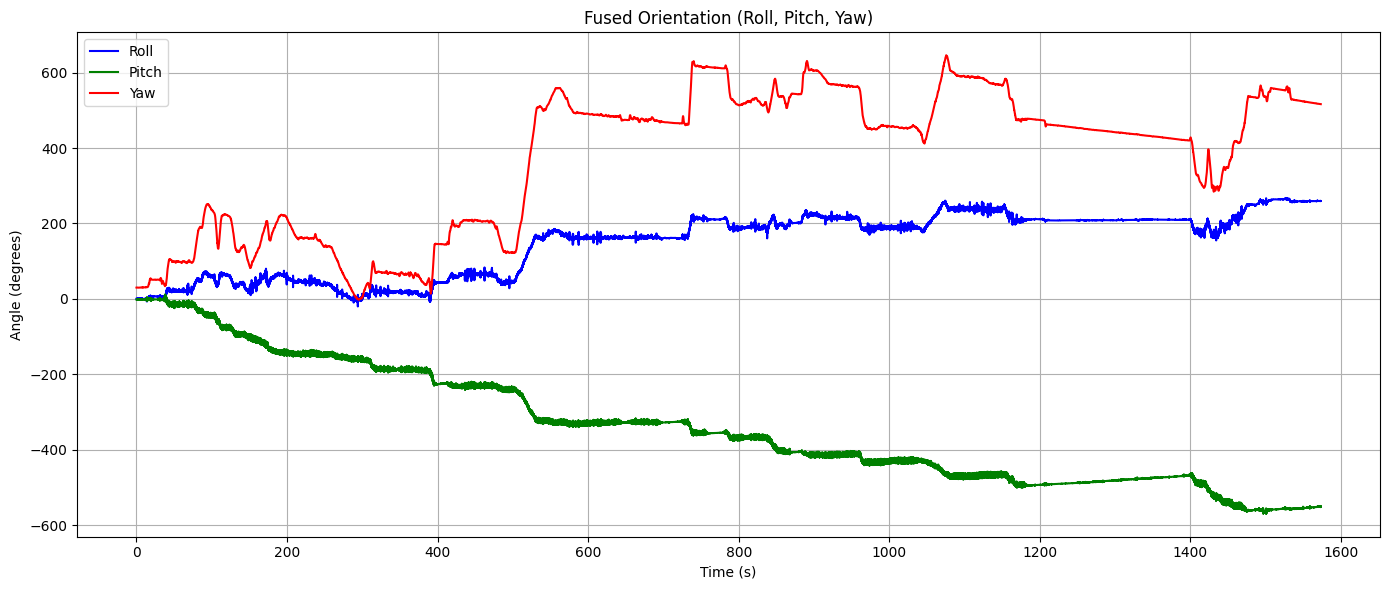

In [69]:
def plot(df, time_col="time_rel", title="Fused Orientation (Roll, Pitch, Yaw)"):
    """
    Plot roll, pitch, and yaw angles on the same graph over time.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns: time_col, 'roll', 'pitch', 'yaw' (angles in degrees).
    time_col : str
        Name of the time column in df.
    title : str
        Title for the plot.
    """
    plt.figure(figsize=(14, 6))

    plt.plot(df[time_col], df["roll"], label="Roll", color="blue")
    plt.plot(df[time_col], df["pitch"], label="Pitch", color="green")
    plt.plot(df[time_col], df["yaw"], label="Yaw", color="red")

    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Video 1:", "-" * 100)
plot(complementary_filter_1)
print("Video 2:", "-" * 100)
plot(complementary_filter_2)

We see the overall trend is better shaped thanks to the data from accelerometer and compass, but there is still a lot of drift.

### Kalman Filter: sensor fusion
This provides the best results:
- Model sensor noise and bias
- Fuse ACCL, GYRO and MAGN
- Estimate full state with uncertainty

Partial eplaination of the Kalman filter:

Variables:
* `x = np.zeros(3)` is the state vector: `[roll, pitch, yaw]`. This is the internal estimate of the current orientation. Each time step, we predict a new value from the gyro, and correct it with the ACCL/MAGN measurements.
* `P = np.eye(3) * 0.1` is the initial state covariance that can be adjusted as needed. It represents uncertainty in the estimate. Starts with small uncertainty (0.1), grows over time unless corrected. Units: (deg²). Note: `eye(3)` is the identity matrix of size 3x3.
* `Q = np.eye(3) * q` processes noise, lower value means more trust in gyroscope. Represents uncertainty in the gyro-derived motion. It tells how much do we think the model of angular motion can drift between time steps. Units: (deg²).
* `R = np.eye(3) * r` is the measurement noise, higher value means less trust in accelerometer and magnetometer. Represents uncertainty in the accelerometer/magnetometer measurements. It tells how noisy are the acc/mag readings used for correcting. Units: (deg²).

Steps:
* `dx = gyro_arr[i] - gyro_arr[i - 1]`
* `x = x + dx` updates the internal state with the gyro-derived change a priori. It is the updated a priori state estimate (predicted).
* `P = P + Q` increases uncertainty because we've moved forward in time without measuring. It is the a priori esetimate covariance (predicted).
* `z = np.array([acc_arr[i, 0], acc_arr[i, 1], yaw_magn_arr[i]])` is the measurements from the accelerometer and magnetometer.
* `S = P + R` is overall uncertainty from all the measurements (innovation or pre-fit residual covariance).
* `K = P @ np.linalg.inv(S)` is the Kalman gain, it is a balance between trusting prediction (P) and measurement (R)
* `y = z - x` is the difference between measured and predicted
* `x = x + K @ y` corrects the estimate a posteriori (updated).
* `P = (np.eye(3) - K) @ P` is the a posteriori covariance estimate (updated).


Values that work well for roll and pitch are the default values `q = 0.01` and `r = 10`.
For yaw, as this is a lot more noisy, `q = 0.0001` and `r = 1000` work well.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Kalman_filter#Details)

In [298]:
def kalman_fuse_orientation_angles(gyro_angles: pd.DataFrame, acc_angles: pd.DataFrame, magn_yaw: pd.DataFrame, q: float = 0.01, r: float = 10) -> pd.DataFrame:
    """
    Fuse roll, pitch, and yaw angles from gyroscope, accelerometer, and magnetometer using a Kalman filter.

    Parameters
    ----------
    gyro_angles : pd.DataFrame
        DataFrame with columns ['roll', 'pitch', 'yaw', 'time_rel'].
    acc_angles : pd.DataFrame
        DataFrame with columns ['roll_accl', 'pitch_accl', 'time_rel'].
    magn_yaw : pd.DataFrame
        DataFrame with columns ['yaw_magn', 'time_rel'].
    q : float
        Process noise covariance (lower value means more trust in gyroscope). Process noise, lower value means more trust in gyroscope.
    r : float
        Measurement noise covariance (higher value means less trust in accelerometer and magnetometer). Measurement noise, higher value means less trust in accelerometer and magnetometer.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['time_rel', 'roll', 'pitch', 'yaw'] (fused angles in degrees).
    """

    # Merge all inputs as a DataFrame on 'time_rel'
    df = pd.merge_asof(
        gyro_angles.sort_values("time_rel"),
        acc_angles.sort_values("time_rel"),
        on="time_rel"
    )
    df = pd.merge_asof(
        df.sort_values("time_rel"),
        magn_yaw.sort_values("time_rel"),
        on="time_rel"
    )

    # Extract arrays for better performance than other methods I tried
    time = df["time_rel"].values
    gyro_arr = df[["roll", "pitch", "yaw"]].values
    acc_arr = df[["roll_accl", "pitch_accl"]].values
    yaw_magn_arr = df["yaw_magn"].values

    # Kalman filter setup
    x = np.zeros(3)
    P = np.eye(3) * 0.1
    Q = np.eye(3) * q
    R = np.eye(3) * r

    fused = [] # List to store fused results
    fused.append([time[0], gyro_arr[0, 0], gyro_arr[1, 0], gyro_arr[2, 0]]) # Initialize with first measurement with the data from the gyro

    n = len(time)

    for i in range(1, n):
        # Predict
        dx = gyro_arr[i] - gyro_arr[i - 1]
        x = x + dx
        P = P + Q # Update covariance

        # Measurement
        z = np.array([acc_arr[i, 0], acc_arr[i, 1], yaw_magn_arr[i]]) # [roll_accl, pitch_accl, yaw_magn]

        # Kalman update
        S = P + R # Innovation covariance
        K = P @ np.linalg.inv(S) # Kalman gain
        y = z - x # Innovation (measurement residual)
        x = x + K @ y # Update state estimate
        P = (np.eye(3) - K) @ P # Update covariance

        fused.append([time[i], x[0], x[1], x[2]])

        # Progress bar
        if i % 100 == 0 or i == n - 1:
            percent = i / n * 100
            bar = "=" * int(percent // 2)
            print(f"\r[{bar:<50}] {percent:.1f}%", end="", flush=True)
    print("\r")

    # Convert to DataFrame
    fused_df = pd.DataFrame(fused, columns=["time_rel", "roll", "pitch", "yaw"])
    return fused_df

fused_orientation_roll_pitch_1 = kalman_fuse_orientation_angles(
    interpolated_roll_pitch_yaw_gyro_1,
    interpolated_roll_pitch_acc_1,
    interpolated_yaw_magn_1
)
fused_orientation_yaw_1 = kalman_fuse_orientation_angles(
    interpolated_roll_pitch_yaw_gyro_1,
    interpolated_roll_pitch_acc_1,
    interpolated_yaw_magn_1,
    q=0.0001, r=1000
)

fused_orientation_roll_pitch_2 = kalman_fuse_orientation_angles(
    interpolated_roll_pitch_yaw_gyro_2,
    interpolated_roll_pitch_acc_2,
    interpolated_yaw_magn_2
)
fused_orientation_yaw_2 = kalman_fuse_orientation_angles(
    interpolated_roll_pitch_yaw_gyro_2,
    interpolated_roll_pitch_acc_2,
    interpolated_yaw_magn_2,
    q=0.0001, r=1000
)

[================================================= ] 100.0%
[================================================= ] 100.0%
[================================================= ] 100.0%
[================================================= ] 100.0%


I decided to remove the first seconds of the footage with the following code sample as otherwise all the graphs start to at an unaccurate value.

In [302]:
def remove_initial_samples(df: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Remove the first n rows from a fused orientation DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns including 'time_rel', 'roll', 'pitch', 'yaw'.
    n : int
        Number of initial samples to remove.

    Returns
    -------
    pd.DataFrame
        DataFrame without the first n rows, index reset.
    """
    if n < 0:
        raise ValueError("n must be non-negative")
    if n >= len(df):
        raise ValueError(f"n ({n}) must be less than the number of rows in df ({len(df)})")

    return df.iloc[n:].reset_index(drop=True)

fused_orientation_roll_pitch_1_trimmed = remove_initial_samples(fused_orientation_roll_pitch_1, n=500)
fused_orientation_yaw_1_trimmed = remove_initial_samples(fused_orientation_yaw_1, n=5000)
fused_orientation_roll_pitch_2_trimmed = remove_initial_samples(fused_orientation_roll_pitch_2, n=500)
fused_orientation_yaw_2_trimmed = remove_initial_samples(fused_orientation_yaw_2, n=5000)

Video 1: ----------------------------------------------------------------------------------------------------


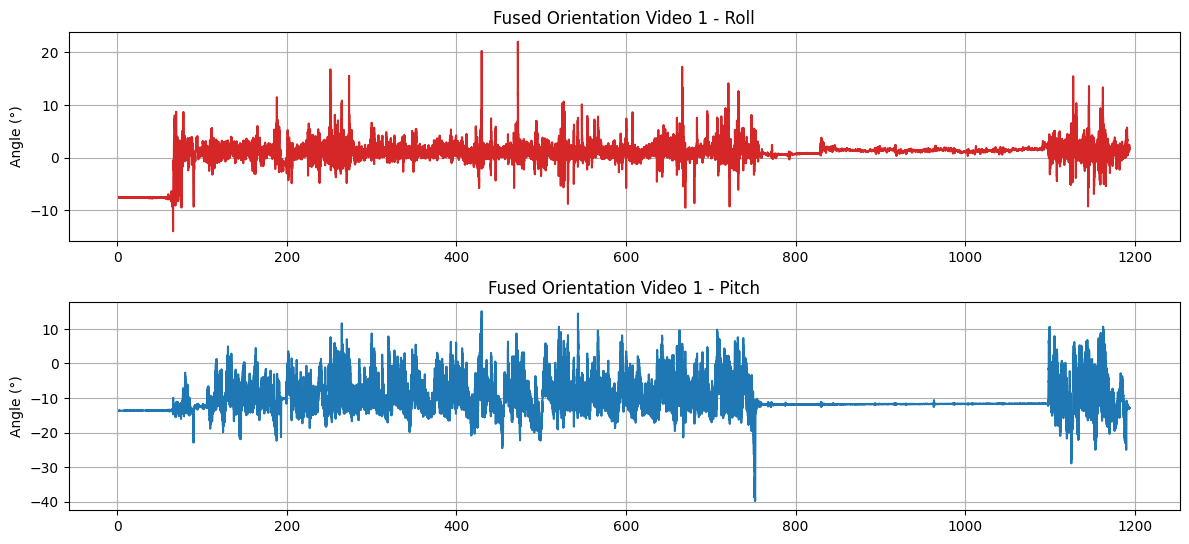

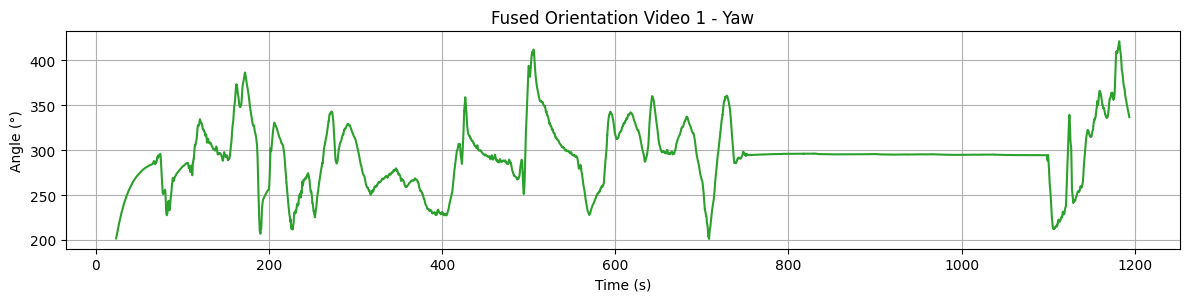

Video 2: ----------------------------------------------------------------------------------------------------


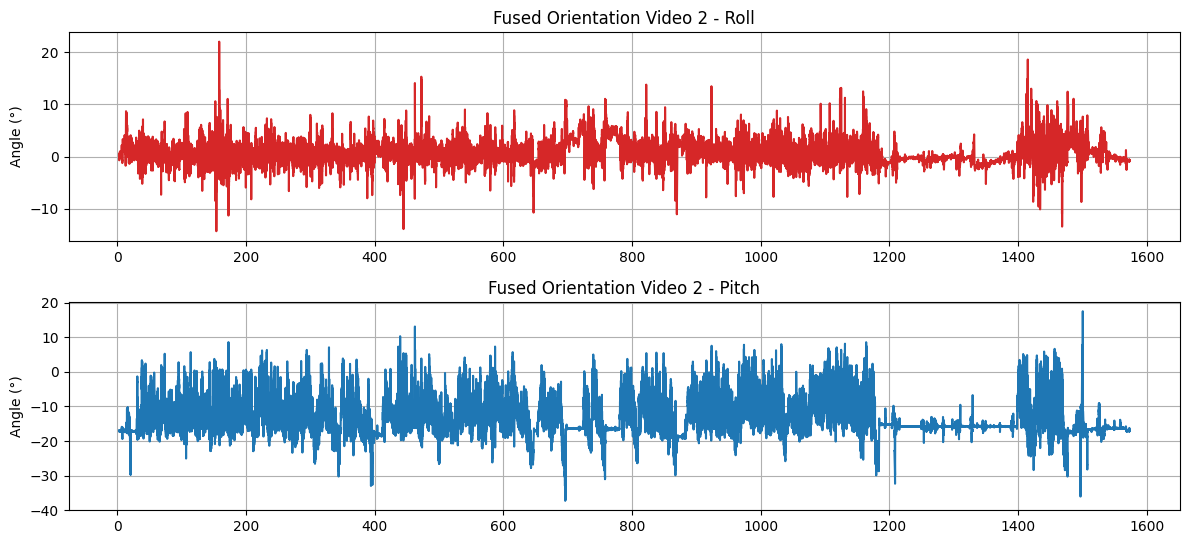

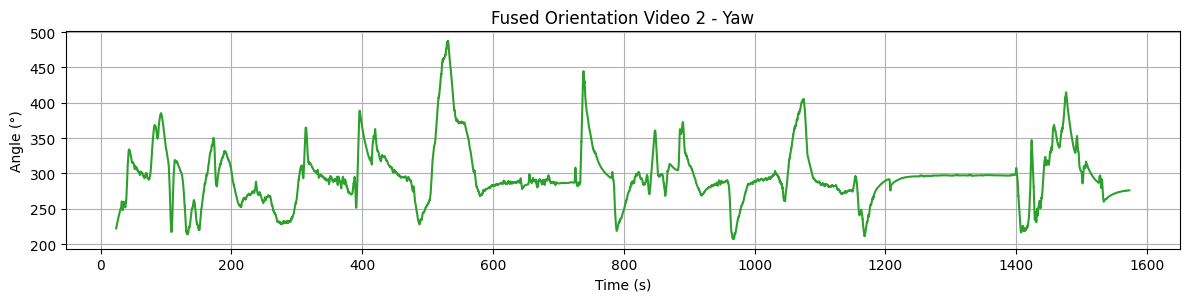

In [303]:
def plot_fused_orientation_roll_pitch(df, time_col="time_rel", title_prefix="Fused Orientation"):
    """
    Plot roll, pitch, and yaw angles over time from a fused orientation DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns: time_col, 'roll', 'pitch', 'yaw' (angles in degrees).
    time_col : str
        Name of the time column in df.
    title_prefix : str
        Title prefix for the plot.
    """
    time = df[time_col]
    roll = df["roll"]
    pitch = df["pitch"]
    yaw = df["yaw"]

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(time, roll, label="Roll", color='tab:red')
    plt.ylabel("Angle (°)")
    plt.title(f"{title_prefix} - Roll")
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time, pitch, label="Pitch", color='tab:blue')
    plt.ylabel("Angle (°)")
    plt.title(f"{title_prefix} - Pitch")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_fused_orientation_yaw(df, time_col="time_rel", title_prefix="Fused Orientation"):
    """
    Plot roll, pitch, and yaw angles over time from a fused orientation DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns: time_col, 'roll', 'pitch', 'yaw' (angles in degrees).
    time_col : str
        Name of the time column in df.
    title_prefix : str
        Title prefix for the plot.
    """
    time = df[time_col]
    roll = df["roll"]
    pitch = df["pitch"]
    yaw = df["yaw"]

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 3)
    plt.plot(time, yaw, label="Yaw", color='tab:green')
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (°)")
    plt.title(f"{title_prefix} - Yaw")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("Video 1:", "-" * 100)
plot_fused_orientation_roll_pitch(fused_orientation_roll_pitch_1_trimmed, title_prefix="Fused Orientation Video 1")
plot_fused_orientation_yaw(fused_orientation_yaw_1_trimmed, title_prefix="Fused Orientation Video 1")
print("Video 2:", "-" * 100)
plot_fused_orientation_roll_pitch(fused_orientation_roll_pitch_2_trimmed, title_prefix="Fused Orientation Video 2")
plot_fused_orientation_yaw(fused_orientation_yaw_2_trimmed, title_prefix="Fused Orientation Video 2")

# Data synchronization and overlay

## Video overlay

Run in the terminal `.venv/bin/gopro-dashboard.py path_to_the_video name_of_the_output_video`, for instance `.venv/bin/gopro-dashboard.py data1/GH010025.MP4 data1GH010025.MP4`. Source: [GoPro Dashboard Overlay GitHub](https://github.com/time4tea/gopro-dashboard-overlay) with a change in the code of the `numpy_func.py` file at line 968.

## Further dive into the mapping

The following functions detect then erase the most noisy fragments of the `GPS5` and replaces it with the average of the values before.

In [ ]:
def most_noisy_gps_windows(df: pd.DataFrame, window_size: int) -> dict:
    """
    Finds the most noisy (highest variance) window of a given size for GPS5_0, GPS5_1, and GPS5_2.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with GPS5_* columns.
    window_size : int
        Size of the window over which to compute variance.

    Returns
    -------
    dict
        Dictionary where keys are GPS5 column names and values are tuples (start_idx, end_idx)
        representing the most noisy window in that column.
    """
    gps_cols = ["GPS5_0", "GPS5_1", "GPS5_2"]
    noisy_windows = {}

    for col in gps_cols:
        if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
            continue  # Skip missing or non-numeric columns

        max_var = -float('inf')
        max_start = 0

        for start in range(0, len(df) - window_size + 1):
            window = df[col].iloc[start:start + window_size]
            var = window.var()
            if var > max_var:
                max_var = var
                max_start = start

        noisy_windows[col] = (max_start, max_start + window_size - 1)

    return noisy_windows

def suppress_noisy_gps_windows(df: pd.DataFrame, window_size: int) -> pd.DataFrame:
    """
    Replaces the most noisy window in each GPS5_* column with the average of the preceding values.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with GPS5_* columns.
    window_size : int
        Size of the noisy window to suppress.

    Returns
    -------
    pd.DataFrame
        A new DataFrame with noisy windows in GPS5_* columns suppressed.
    """
    df_cleaned = df.copy()
    noisy_windows = most_noisy_gps_windows(df_cleaned, window_size)

    for col, (start_idx, end_idx) in noisy_windows.items():
        if col not in df_cleaned.columns or not pd.api.types.is_numeric_dtype(df_cleaned[col]):
            continue

        # Compute the mean of the previous values before the noisy window
        avg_start = max(0, start_idx - window_size)
        avg_end = start_idx
        preceding_values = df_cleaned[col].iloc[avg_start:avg_end]

        if not preceding_values.empty:
            mean_value = preceding_values.mean()
        else:
            mean_value = df_cleaned[col].iloc[start_idx:end_idx + 1].mean()  # fallback

        df_cleaned.loc[start_idx:end_idx, col] = mean_value

    return df_cleaned

dfs_video_1_without_gps_noise_1 = suppress_noisy_gps_windows(dfs_video_1["GPS5"], window_size=4000)
#dfs_video_1_without_gps_noise_1 = suppress_noisy_gps_windows(dfs_video_1_without_gps_noise_1, window_size=500)
dfs_video_1_without_gps_noise_2 = suppress_noisy_gps_windows(dfs_video_2["GPS5"], window_size=1500)
dfs_video_1_without_gps_noise_2 = suppress_noisy_gps_windows(dfs_video_1_without_gps_noise_2, window_size=200)

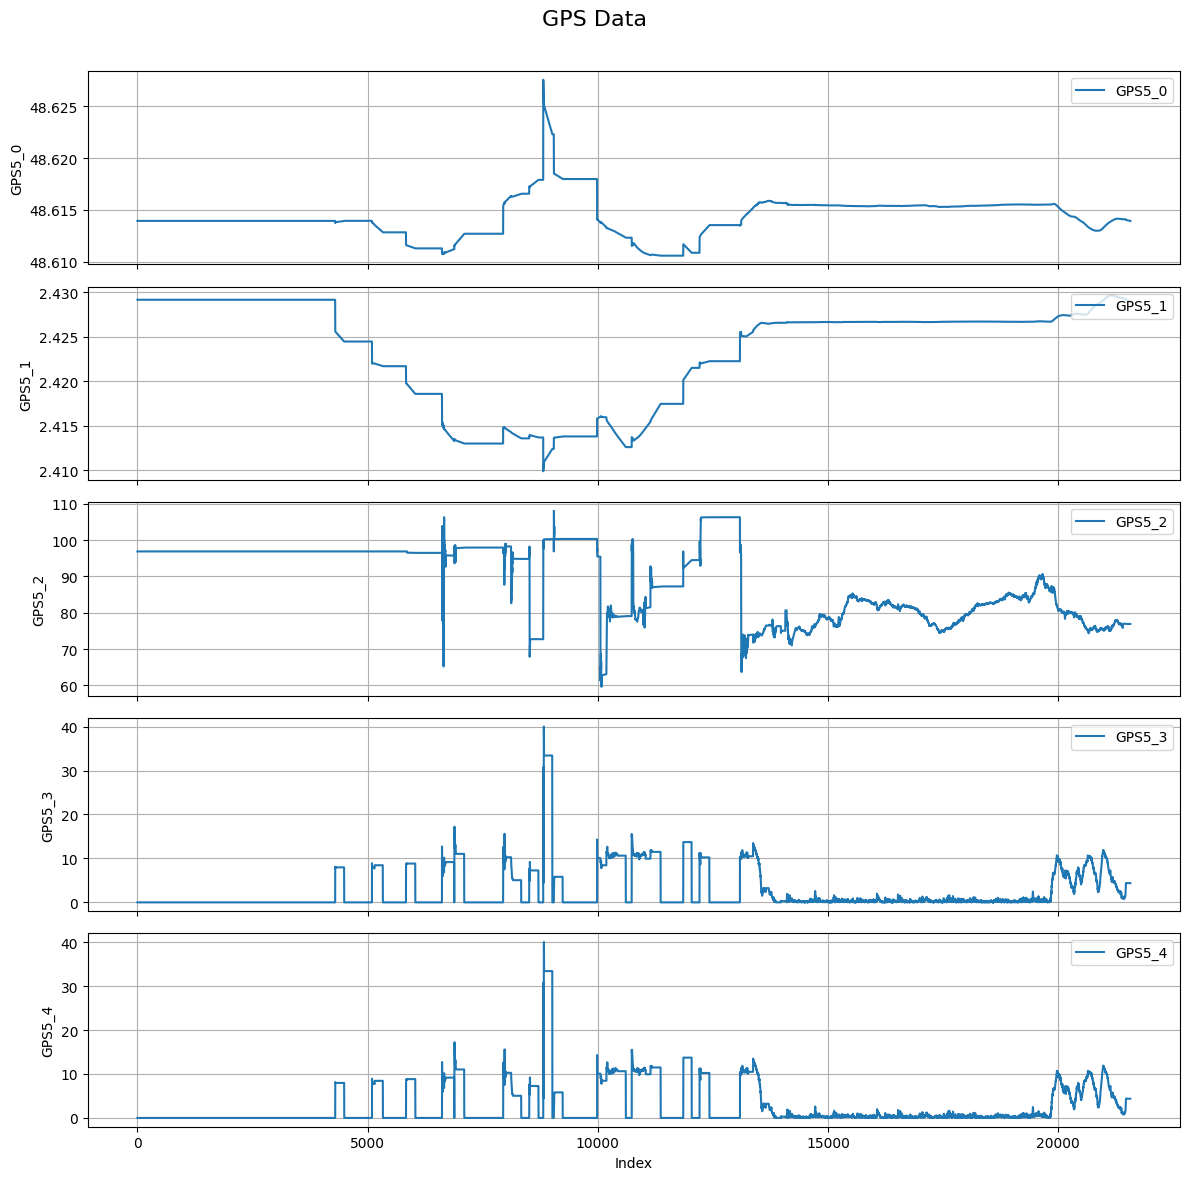

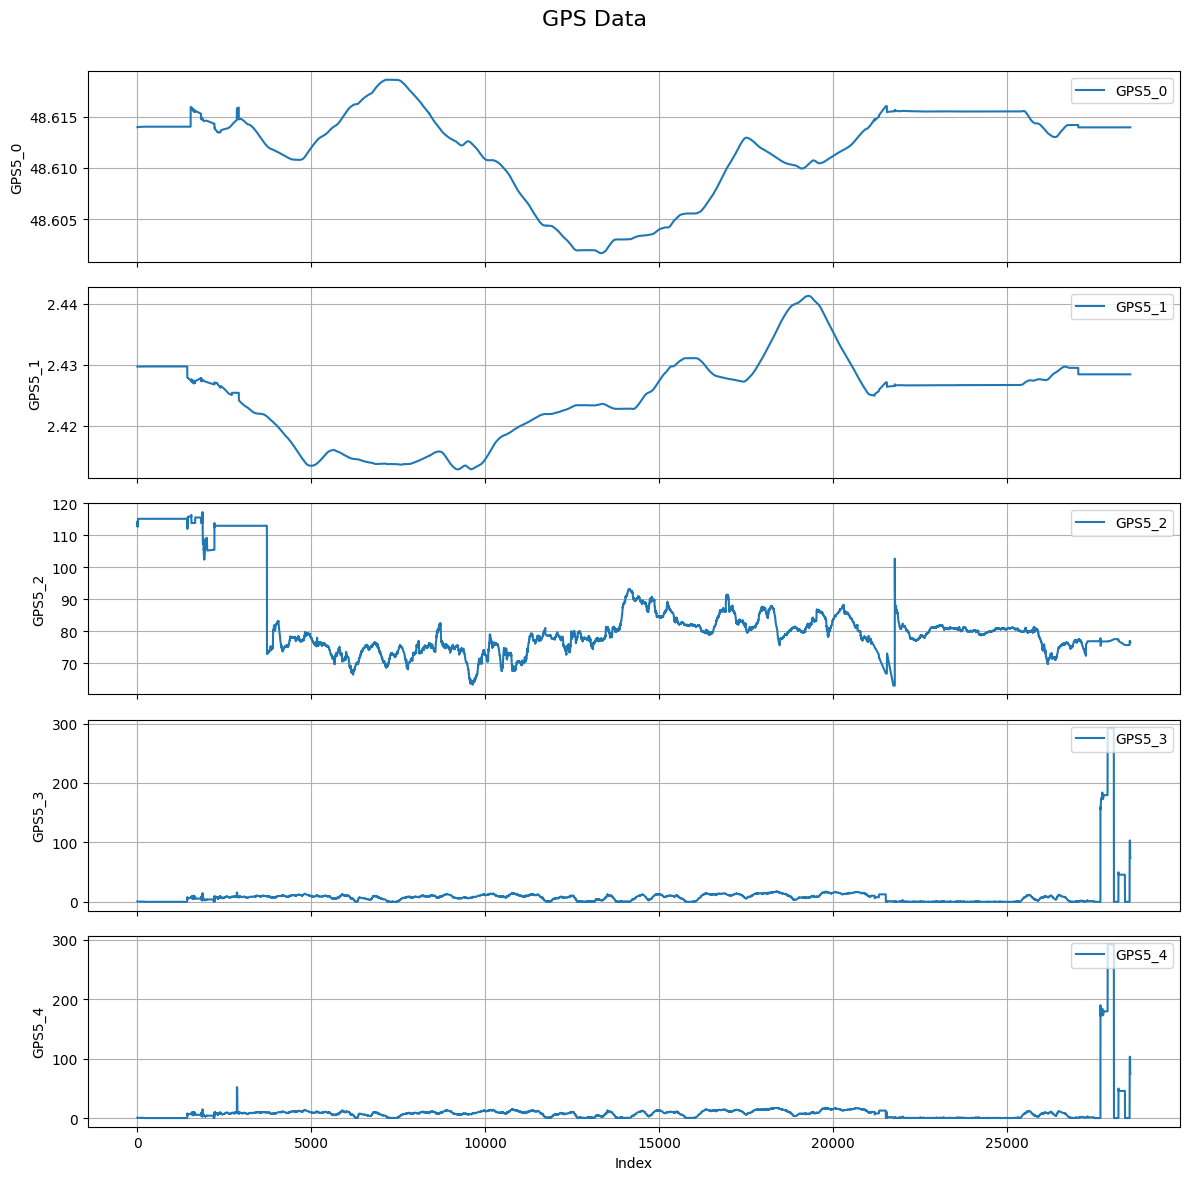

In [294]:
def display_all_gps_components(gps_df: pd.DataFrame, time_col: str = None, title_prefix="GPS Data") -> None:
    """
    Display all 5 components of GPS data in separate subplots using matplotlib.

    Parameters
    ----------
    gps_df : pd.DataFrame
        DataFrame containing at least 5 columns (e.g., ['lat', 'lon', 'alt', 'speed', 'fix']).
    time_col : str, optional
        If provided, use this column as x-axis (e.g., 'time_rel'). Otherwise, index is used.
    title_prefix : str
        Prefix for each subplot's title.
    """

    # Use index or time_col as x-axis
    if time_col and time_col in gps_df.columns:
        x = gps_df[time_col]
    else:
        x = gps_df.index

    columns_to_plot = gps_df.columns[:5]

    fig, axs = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
    fig.suptitle(f"{title_prefix}", fontsize=16)

    for i, col in enumerate(columns_to_plot):
        axs[i].plot(x, gps_df[col], label=col, color='tab:blue')
        axs[i].set_ylabel(col)
        axs[i].grid(True)
        axs[i].legend(loc='upper right')

    axs[-1].set_xlabel('Time' if time_col else 'Index')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


display_all_gps_components(dfs_video_1_without_gps_noise_1)
display_all_gps_components(dfs_video_1_without_gps_noise_2)

In [273]:
import folium

def plot_gps_route(df: pd.DataFrame) -> folium.Map:
    """
    Plots a GPS route on an interactive OpenStreetMap using folium.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns 'GPS5_0' (latitude), 'GPS5_1' (longitude).

    Returns
    -------
    folium.Map
        The folium Map object showing the GPS path.
    """
    if not {'GPS5_0', 'GPS5_1'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'GPS5_0' and 'GPS5_1' columns")

    gps_coords = list(zip(df["GPS5_0"], df["GPS5_1"]))

    # Center map on the first coordinate
    start_location = gps_coords[0]
    gps_map = folium.Map(location=start_location, zoom_start=15)

    # Add the route as a PolyLine
    folium.PolyLine(gps_coords, color="blue", weight=3, opacity=0.8).add_to(gps_map)

    # Add start and end markers
    folium.Marker(gps_coords[0], popup="Start", icon=folium.Icon(color="green")).add_to(gps_map)
    folium.Marker(gps_coords[-1], popup="End", icon=folium.Icon(color="red")).add_to(gps_map)

    return gps_map

In [295]:
plot_gps_route(dfs_video_1_without_gps_noise_1)

In [282]:
plot_gps_route(dfs_video_1_without_gps_noise_2)

The first video seems way too noisy while the second one is OK.